# Phân cụm thị trường cầu thủ bóng đá

## Data and Setup
___

### ** Import thư viện **

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder,  StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import math

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from matplotlib.gridspec import GridSpec
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

### ** Đọc dữ liệu từ các file csv và lưu vào các DataFrame **

In [33]:
players = pd.read_csv('./clean_data/players.csv')
countries = pd.read_csv('./clean_data/countries.csv')
clubs = pd.read_csv('./clean_data/clubs.csv')

### ** Hợp hệ số "points" của quốc gia tổ chức giải đấu vào bảng players để khảo sát và xóa các cột dư thừa"

In [34]:
players = players.merge(countries[['name', 'points']], how='left', left_on='country', right_on='name')
players = players.rename(columns={'points': 'point_of_tournament', 'name_x': 'name'})
players = players.drop('name_y', axis=1)
players.drop(['shirt_number'], axis=1, inplace=True)

players_root = players.copy()

#### ``1. Mã hóa dữ liệu biến danh mục``

In [35]:
players['position'].unique()

array(['F', 'M', 'D', 'G'], dtype=object)

In [36]:
# Mã hóa cột 'position'

label_position_encoder = LabelEncoder()
players['position'] = label_position_encoder.fit_transform(players['position'])

mapping = dict(zip(label_position_encoder.classes_, label_position_encoder.transform(label_position_encoder.classes_)))
print("Giá trị ban đầu sang giá trị mã hóa:")
print(mapping)

Giá trị ban đầu sang giá trị mã hóa:
{'D': 0, 'F': 1, 'G': 2, 'M': 3}


In [37]:
players['preferred_foot'].unique()

array(['Left', 'Right', 'Both'], dtype=object)

In [38]:
# Mã hóa cột 'preferred_foot'

label_foot_encoder = LabelEncoder()
players['preferred_foot'] = label_foot_encoder.fit_transform(players['preferred_foot'])

mapping = dict(zip(label_foot_encoder.classes_, label_foot_encoder.transform(label_foot_encoder.classes_)))

print("Giá trị ban đầu sang giá trị mã hóa:")
print(mapping)

Giá trị ban đầu sang giá trị mã hóa:
{'Both': 0, 'Left': 1, 'Right': 2}


In [39]:
players.head(3)

name  market_value                club    country  \
0      Luciano Gondou          7400  Argentinos Juniors  Argentina   
1  Maximiliano Romero          2500  Argentinos Juniors  Argentina   
2        Gastón Verón          1200  Argentinos Juniors  Argentina   

                       league nationality  age  height  preferred_foot  \
0  Liga Profesional de Fútbol         ARG   22     189               1   
1  Liga Profesional de Fútbol         ARG   25     179               2   
2  Liga Profesional de Fútbol         ARG   22     184               2   

   position  ...  tactical  defending  creativity  saves  anticipation  \
0         1  ...        51         33          49      0             0   
1         1  ...        54         32          47      0             0   
2         1  ...        45         29          48      0             0   

   ball_distribution  aerial  avg_score_last_12_months  \
0                  0       0                      7.14   
1                  0       0                      6.86   
2                  0       0                      6.80   

   appearances_last_12_months  point_of_tournament  
0                          33               1858.0  
1                          37               1858.0  
2                          34               1858.0  

[3 rows x 22 columns]

#### ``2. Chuẩn hóa dữ liệu``

#### Xử lý ngoại lệ trước khi chuẩn hóa dữ liệu

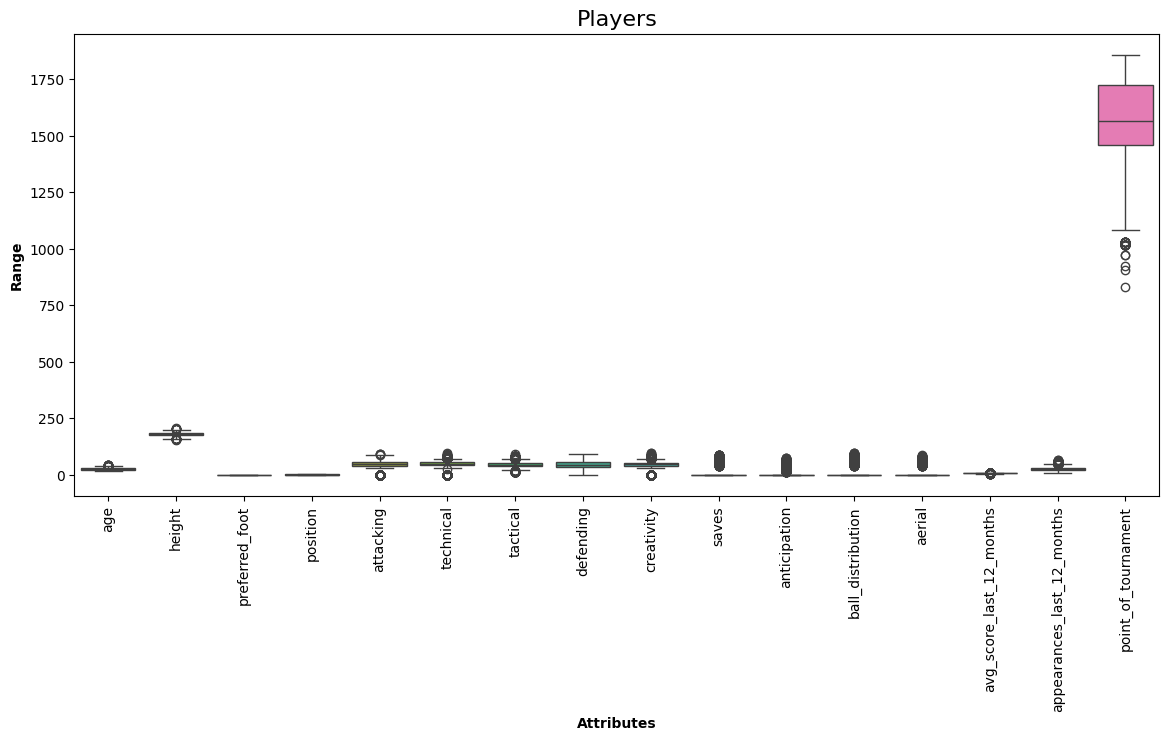

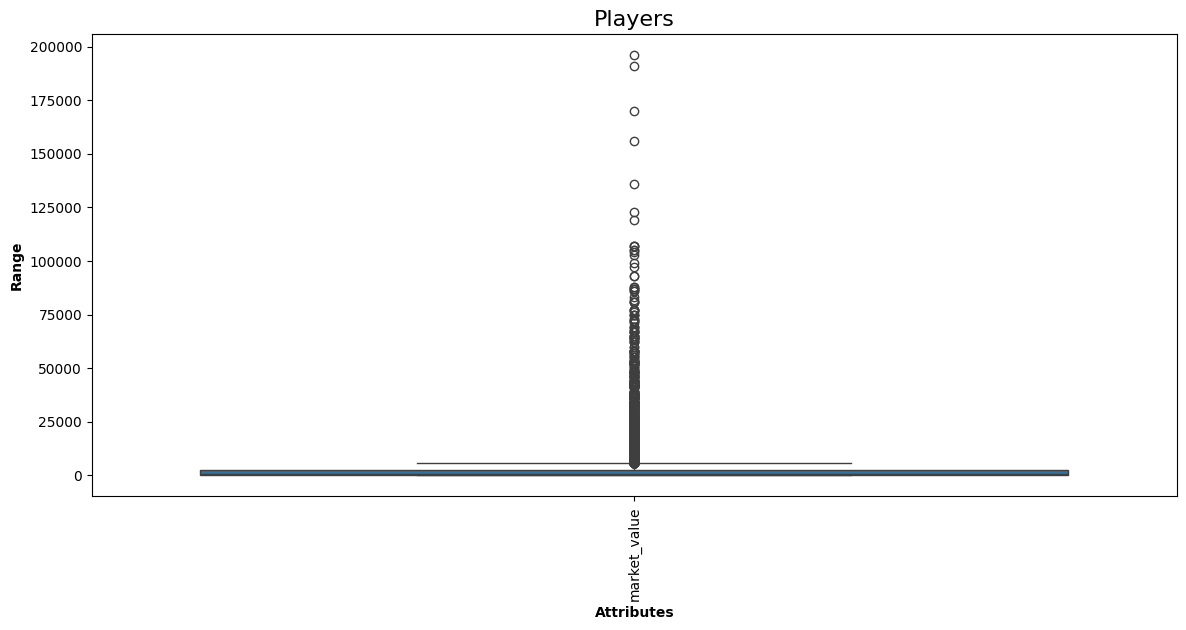

In [40]:
# Đồ thị trước khi xử lý ngoại lệ

players = players.select_dtypes(include=['float64', 'int64', 'int32'])

def show_boxplot(df, title):
    plt.rcParams['figure.figsize'] = [14,6]
    sns.boxplot(data = df, orient="v")
    plt.title(title, fontsize = 16)
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')
    plt.xticks(rotation=90)
    plt.show()
    
show_boxplot(players.drop(['market_value'], axis=1),"Players")
show_boxplot(players['market_value'].to_frame(),"Players")

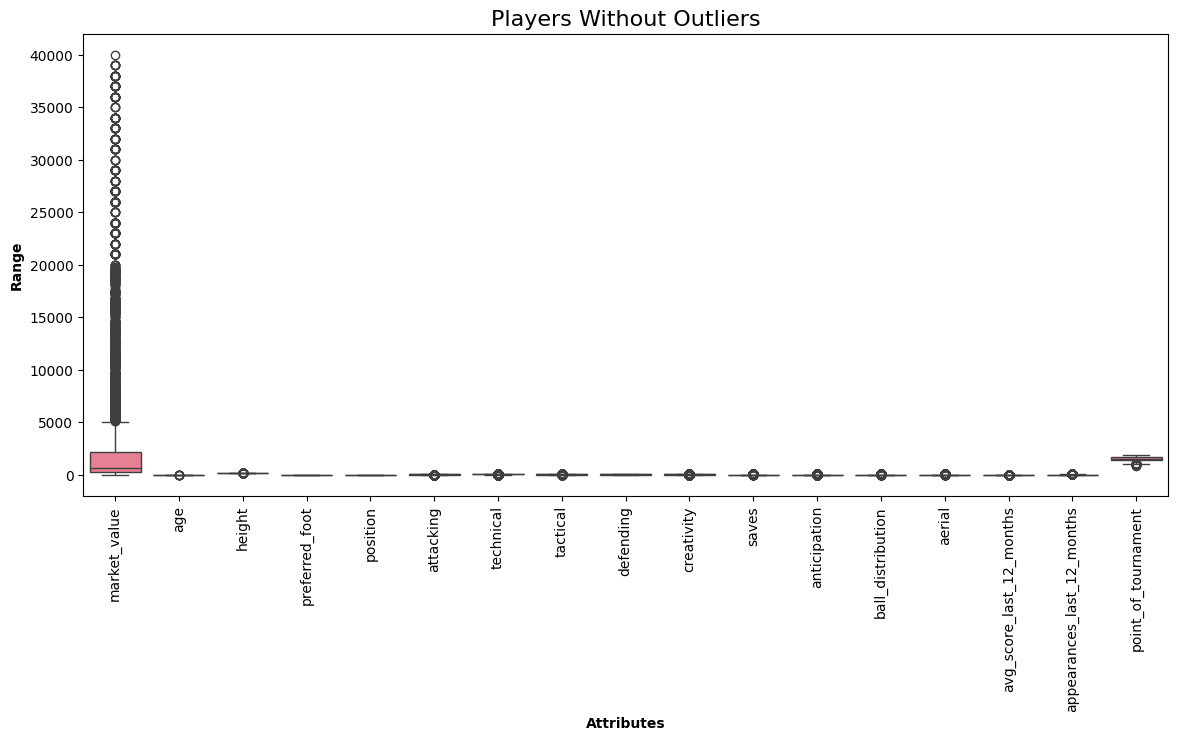

In [41]:
# Xử lý ngoại lệ

def remove_outliers(data):
    df = data.copy()
    for col in list(df.columns):
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

players = remove_outliers(players)

show_boxplot(players, "Players Without Outliers")

#### Tiến hành chuẩn hóa dữ liệu

In [42]:
# Chuẩn hóa dữ liệu 

players_origin = players.copy()

min_max = MinMaxScaler()

players = pd.DataFrame(min_max.fit_transform(players), columns=players.columns)

players_encoded = players.copy()

In [43]:
players.head(3)

market_value       age  height  preferred_foot  position  attacking  \
0      0.184531  0.222222    0.66             0.5  0.333333   0.781609   
1      0.061961  0.333333    0.46             1.0  0.333333   0.712644   
2      0.029442  0.222222    0.56             1.0  0.333333   0.735632   

   technical  tactical  defending  creativity  saves  anticipation  \
0   0.617978    0.5000   0.358696    0.526882    0.0           0.0   
1   0.539326    0.5375   0.347826    0.505376    0.0           0.0   
2   0.573034    0.4250   0.315217    0.516129    0.0           0.0   

   ball_distribution  aerial  avg_score_last_12_months  \
0                0.0     0.0                  0.438424   
1                0.0     0.0                  0.300493   
2                0.0     0.0                  0.270936   

   appearances_last_12_months  point_of_tournament  
0                    0.410714                  1.0  
1                    0.482143                  1.0  
2                    0.428571                  1.0

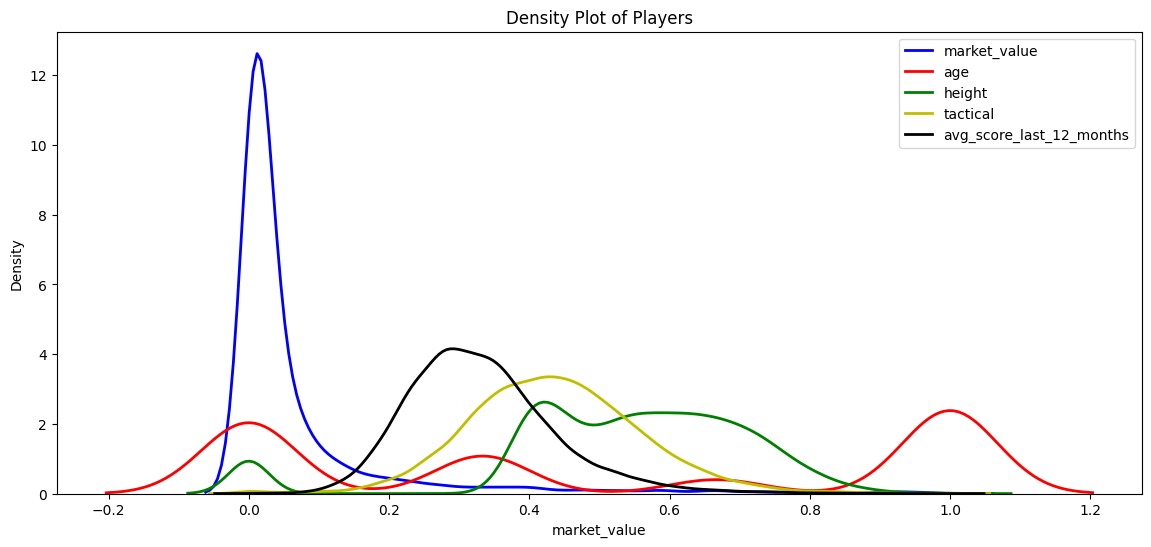

In [44]:
sns.kdeplot(players['market_value'], color ='b', linewidth=2)
sns.kdeplot(players['position'], color ='r', linewidth=2)
sns.kdeplot(players['attacking'], color ='g', linewidth=2)
sns.kdeplot(players['tactical'], color ='y', linewidth=2)
sns.kdeplot(players['avg_score_last_12_months'], color ='black', linewidth=2)
plt.legend(['market_value', 'age', 'height', 'tactical', 'avg_score_last_12_months'])
plt.title('Density Plot of Players')
plt.show()

#### Tiến hành lựa chọn đặc trưng

In [45]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

players = variance_threshold_selector(players)

players.head(3)

market_value       age  height  preferred_foot  position  attacking  \
0      0.184531  0.222222    0.66             0.5  0.333333   0.781609   
1      0.061961  0.333333    0.46             1.0  0.333333   0.712644   
2      0.029442  0.222222    0.56             1.0  0.333333   0.735632   

   technical  tactical  defending  creativity  saves  anticipation  \
0   0.617978    0.5000   0.358696    0.526882    0.0           0.0   
1   0.539326    0.5375   0.347826    0.505376    0.0           0.0   
2   0.573034    0.4250   0.315217    0.516129    0.0           0.0   

   ball_distribution  aerial  avg_score_last_12_months  \
0                0.0     0.0                  0.438424   
1                0.0     0.0                  0.300493   
2                0.0     0.0                  0.270936   

   appearances_last_12_months  point_of_tournament  
0                    0.410714                  1.0  
1                    0.482143                  1.0  
2                    0.428571                  1.0

### Lựa chọn tham số

In [46]:
# Lựa chọn tham số perplexity

perplexity = np.arange(10, 210, 10)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, perplexity=i)
    reduced = model.fit_transform(players)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

``Nhận xét``:
- Vì dữ liệu cầu thủ lớn, giá trị của các biến dữ liệu của các cầu thủ ít tách biệt và phân bố khá đều. Do đó, khi tăng **perplexity** thì độ phân kỳ KL giảm dần, nhưng làm giảm khả năng phân biệt các điểm dữ liệu tương tự.
- Lựa chọn tham số perplexity = 200 cho ra độ phân kỳ KL là 1.01 để dữ liệu trực quan cân bằng giữa việc trực quan hóa dữ liệu toàn cục mượt mà nhưng vẫn giữ được khả năng phân biệt giữa các điểm dữ liệu tương tự ở gần.

In [47]:
# Sử dụng T-SNE giảm chiều dữ liệu

players = players_encoded
tsne = TSNE(n_components=2, perplexity=200, random_state=42)
players_tsne = tsne.fit_transform(players)

tsne.kl_divergence_

1.0100011825561523

In [48]:
players_tsne_df = pd.DataFrame(players_tsne, columns=['x', 'y'])
px.scatter(players_tsne_df, x='x', y='y', color=players['position'])

### **``3. Các mô hình phân cụm dữ liệu``**
--------

### ``A. Hierarchical Clustering``: phương pháp phân cụm phân cấp

- Ưu điểm: không yêu cầu khai báo trước số lượng cụm. Thay vào đó, thuật toán chỉ yêu cầu xác định trước thước đo về sự khác biệt giữa các cụm (không giao nhau), dựa trên sự khác biệt từng cặp giữa các quan sát trong hai cụm.
- Biểu diễn phân cấp theo đồ thị dendrogram 

![markdown](https://imgur.com/aJhvsa8.png)

- Đây là 1 dạng của ``cây quyết định nhị phân``
- Chia thành 2 chiến lược : ``Hợp nhất (agglomerative)`` và ``phân chia (divisive)``

##### ``Cây quyết định nhị phân``

- Cây quyết định nhị phân là một mô hình học máy sử dụng cấu trúc dạng cây để phân loại dữ liệu. Cây được tạo thành từ các nút (node) và nhánh (branch). Mỗi nút đại diện cho một câu hỏi hoặc quyết định, và mỗi nhánh đại diện cho một câu trả lời hoặc kết quả có thể xảy ra.
- Nhị phân -> mỗi nút chỉ có 2 nhánh con (tương ứng với true / false)

##### ``Chiến lược hợp nhất ``

- Đi từ ``dưới`` lên ``trên``, bắt đầu ở các ``nút lá``
- Ban đầu ``mỗi quan sát`` được xem là ``1 cụm tách biệt``
- Ở mỗi level, tìm cách hợp 1 cặp cụm thành 1 cụm duy nhất cho level cao hơn
- Cụm mới này tương ứng với các node quyết định (non-leaf node)
- 1 cặp đc chọn để hợp nhất là những cụm trung gian không giao nhau 


![markdown](https://imgur.com/SWdmUac.png)


*Các bước xác định:*
- Bước 1: Gán mỗi quan sát là 1 cụm 
- Bước 2: Gộp 2 cụm có khoảng cách gần nhất lại thành 1 cụm (sử dụng Euclidian cho điểm, khoảng cách trung bình cho cụm)
- Lặp lại cho đến khi chỉ còn 1 cụm chứa hết tất cả

*Có 4 cách để xác định khoảng cách giữa các cụm:*
- Ward linkage: đo khoảng cách giữa 2 tâm cụm
- Sinlge linkage: cặp điểm gần nhất của 2 cụm
- Complete linkage: cặp điểm xa nhất của 2 cụm
- Group average: trung bình toàn bộ khoảng cách giữa các cặp điểm từ 2 cụm

##### ``Chiến lược phân chia``

- Chiều ngược lại, từ trên xuống
- Tại mỗi level ta phân chia đệ quy thành 2 cụm mới sao cho có sự tách biệt nhau lớn nhất 

![markdown](https://imgur.com/SWdmUac.png)

### **``Áp dụng``**
--------

Text(0, 0.5, 'dissimilarity metric cluster')

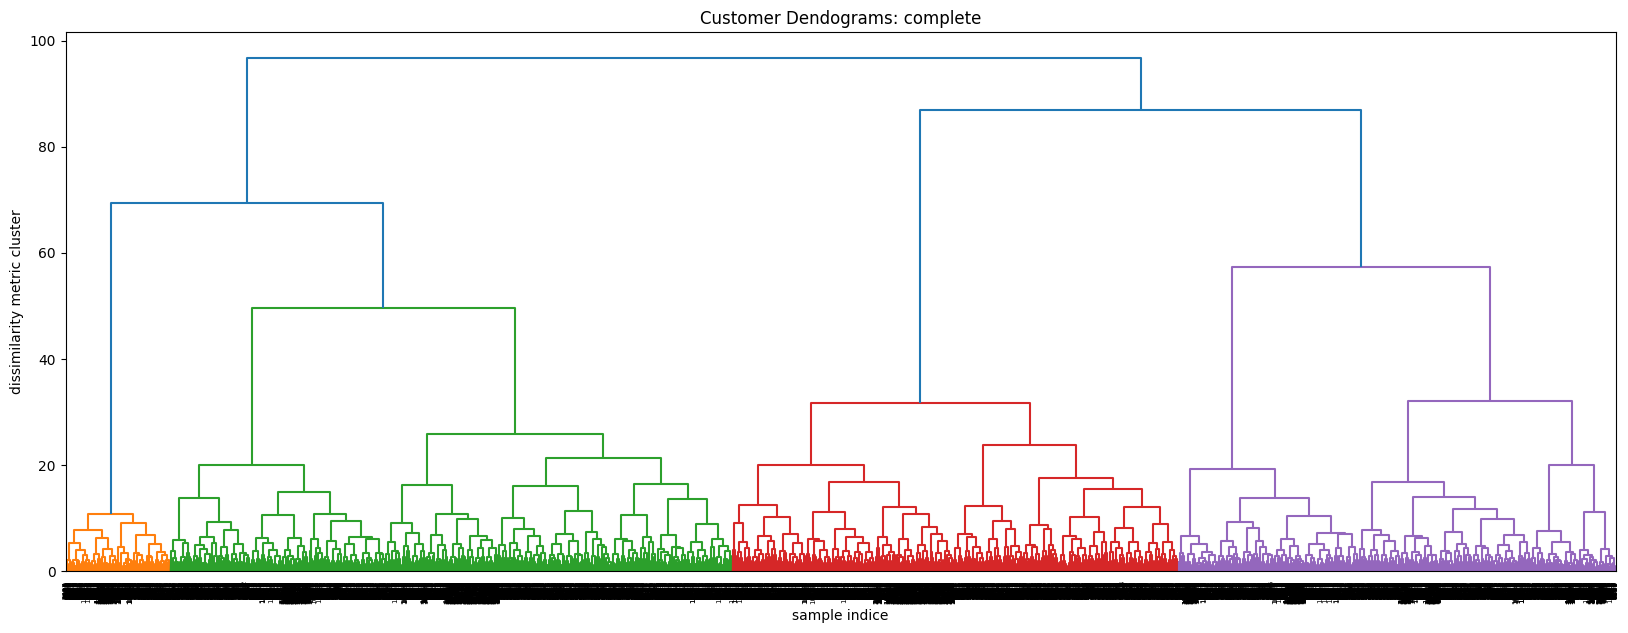

In [49]:
# Đồ thị Dendograms sử dụng phương pháp: Complete-linkage

plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: complete")
dend = shc.dendrogram(shc.linkage(players_tsne, method='complete'))
# plt.axhline(65, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

Text(0, 0.5, 'dissimilarity metric cluster')

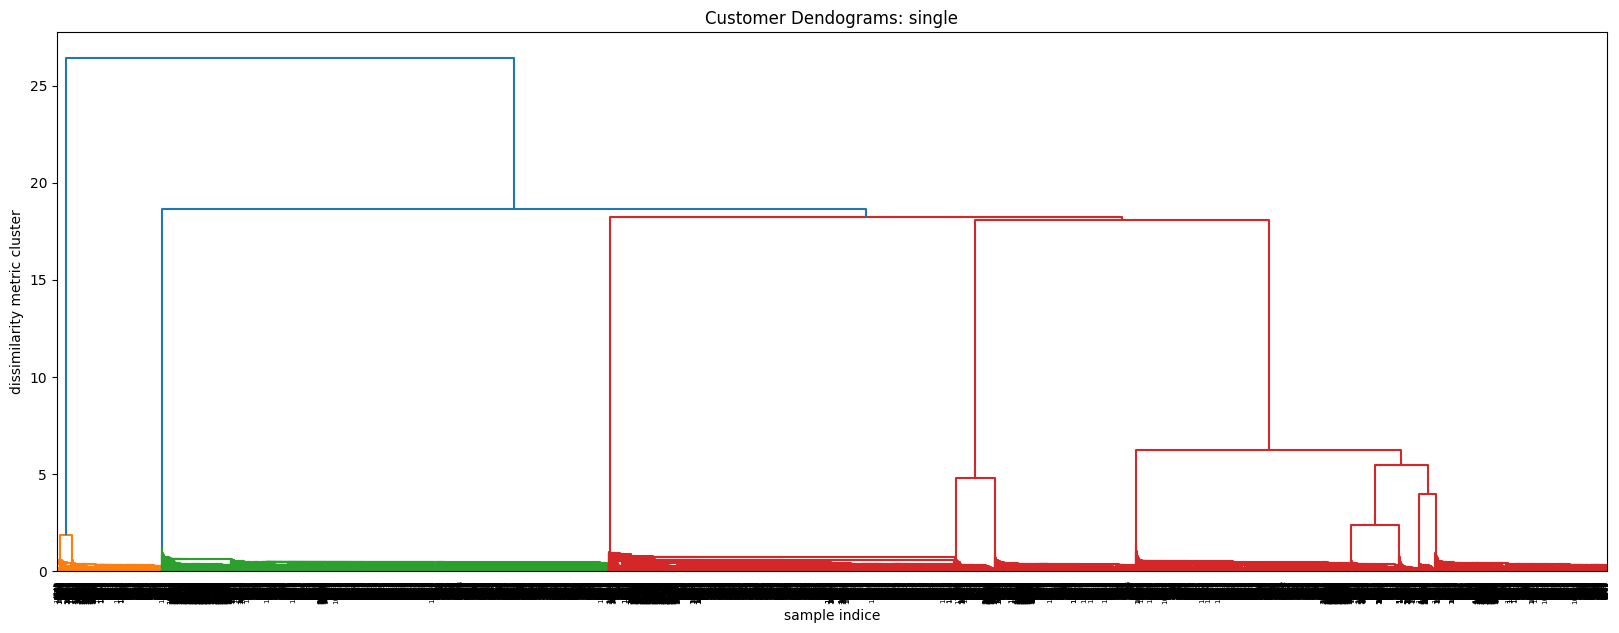

In [50]:
# Đồ thị Dendograms sử dụng phương pháp: Single-linkage


plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: single")
dend = shc.dendrogram(shc.linkage(players_tsne, method='single'))
# plt.axhline(65, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

Text(0, 0.5, 'dissimilarity metric cluster')

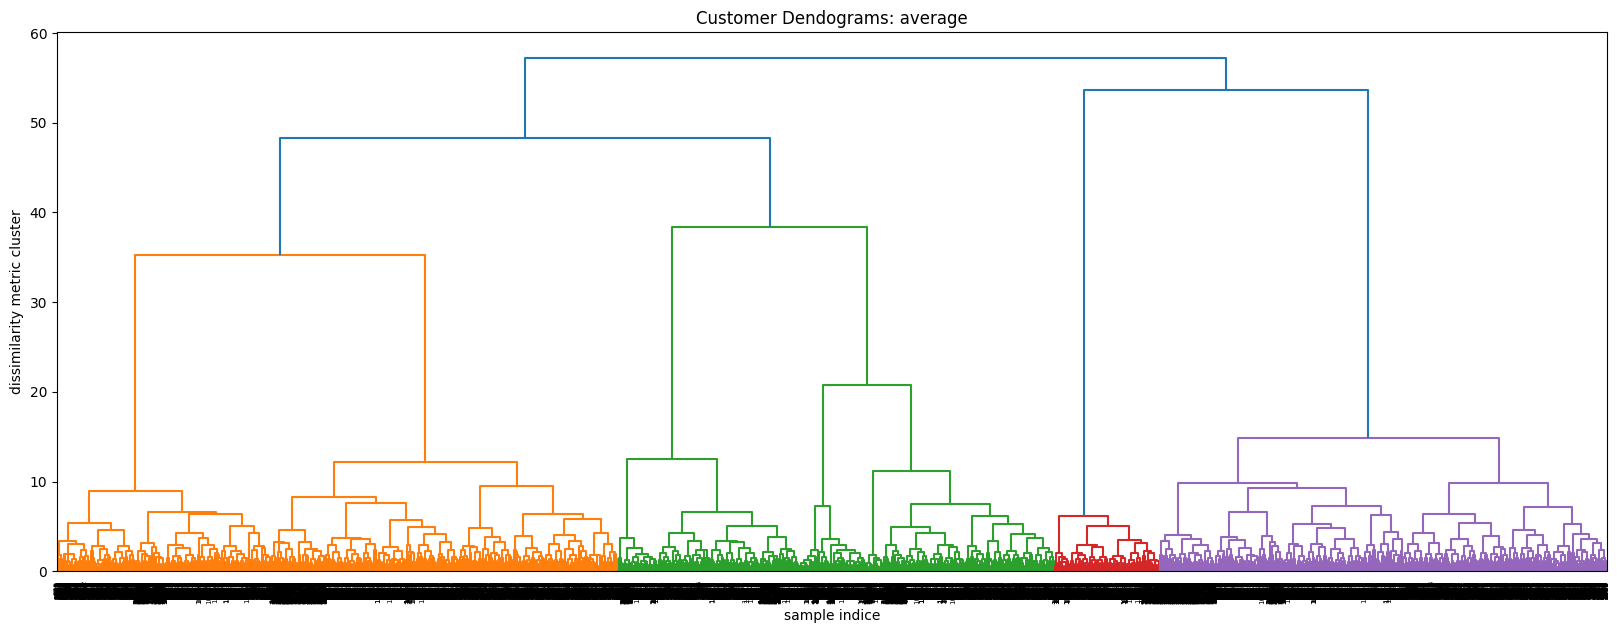

In [51]:
# Đồ thị Dendograms sử dụng phương pháp: Group-average

plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: average")
dend = shc.dendrogram(shc.linkage(players_tsne, method='average'))
# plt.axhline(12, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

Text(0, 0.5, 'dissimilarity metric cluster')

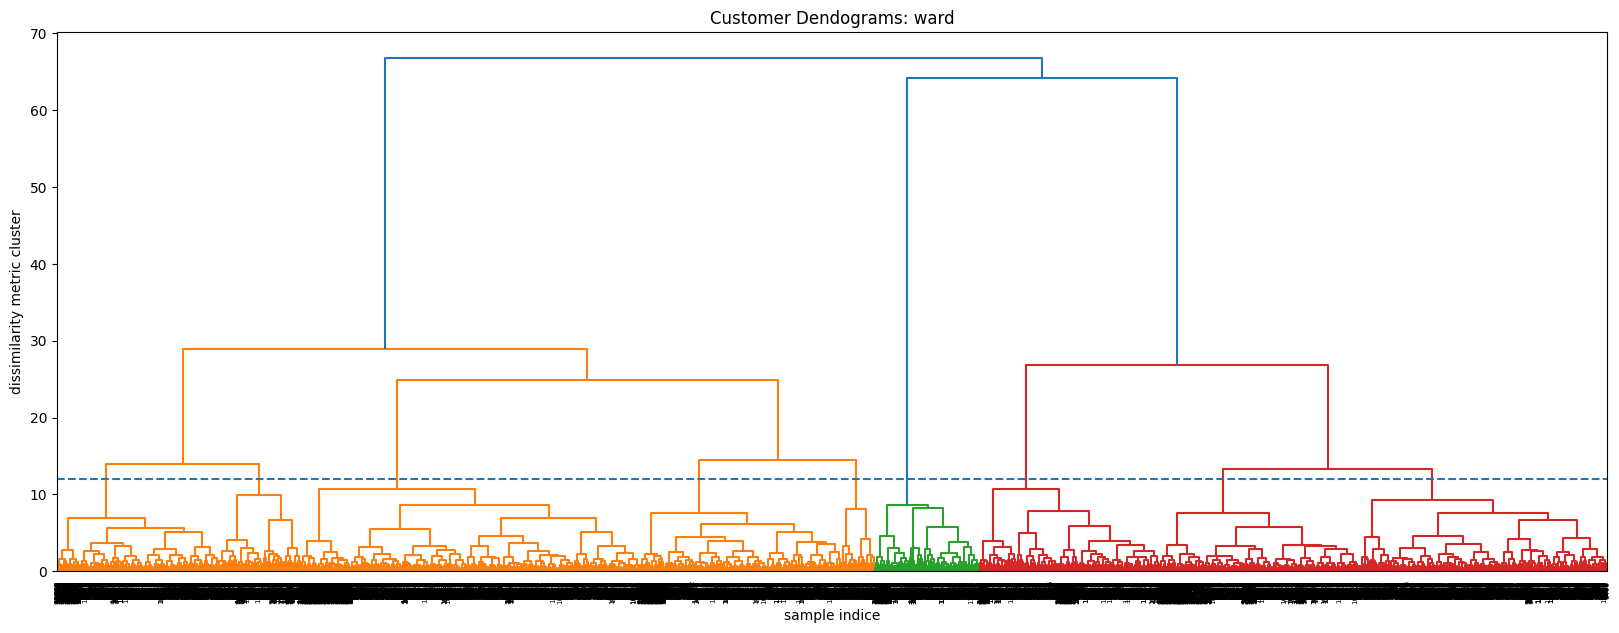

In [52]:
# Đồ thị Dendograms sử dụng phương pháp: Ward-linkage

plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: ward")
dend = shc.dendrogram(shc.linkage(players, method='ward'))
plt.axhline(12, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

## Chọn thước đo về sự khác biệt giữa các cụm là 12, Với phương pháp Ward-linkage xác định được 9 cụm.

In [53]:
# Gom nhóm dữ liệu theo số lượng cụm đã chọn và theo từng phương pháp đo khoảng cách

cluster = AgglomerativeClustering(n_clusters=9, linkage='complete')
labels_com = cluster.fit_predict(players)

cluster = AgglomerativeClustering(n_clusters=9, linkage='single')
labels_sing = cluster.fit_predict(players)

cluster = AgglomerativeClustering(n_clusters=9, linkage='average')
labels_aver = cluster.fit_predict(players)

cluster = AgglomerativeClustering(n_clusters=9, linkage='ward')
labels_ward = cluster.fit_predict(players)

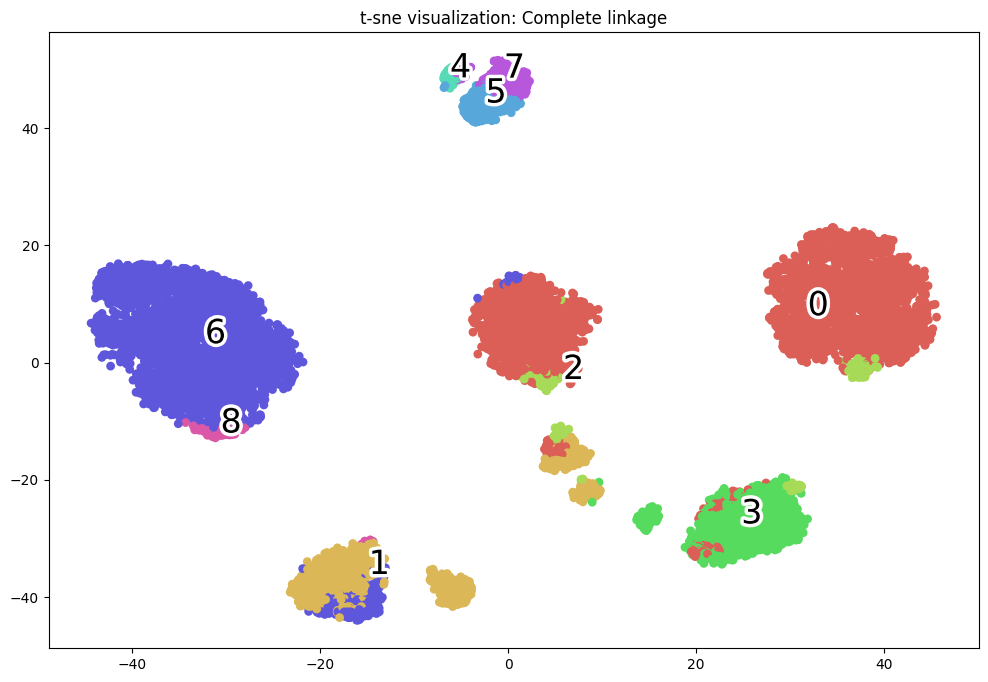

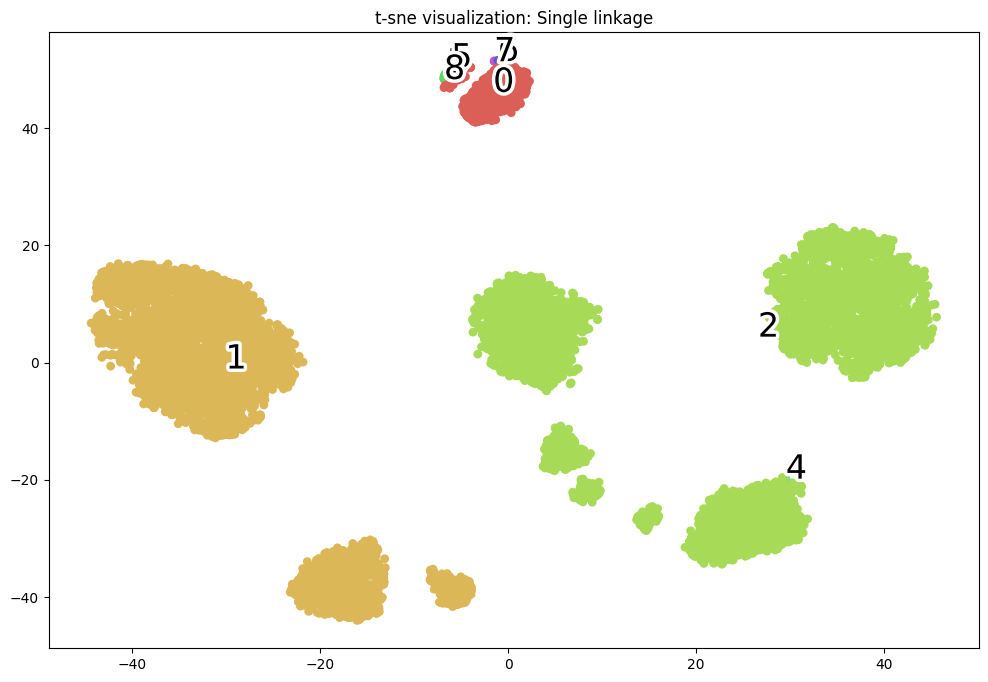

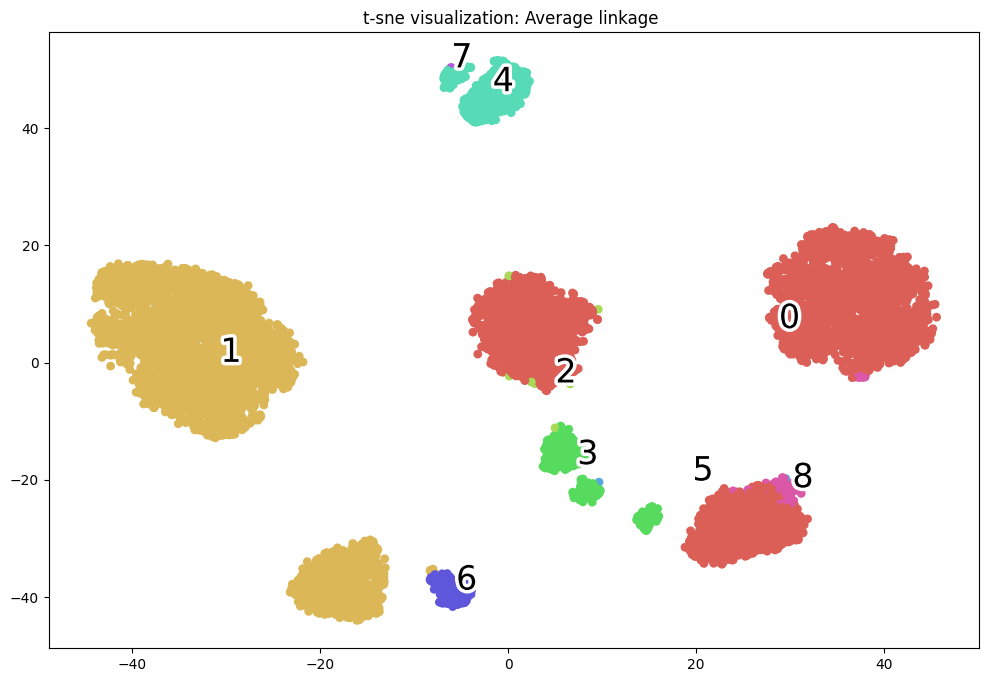

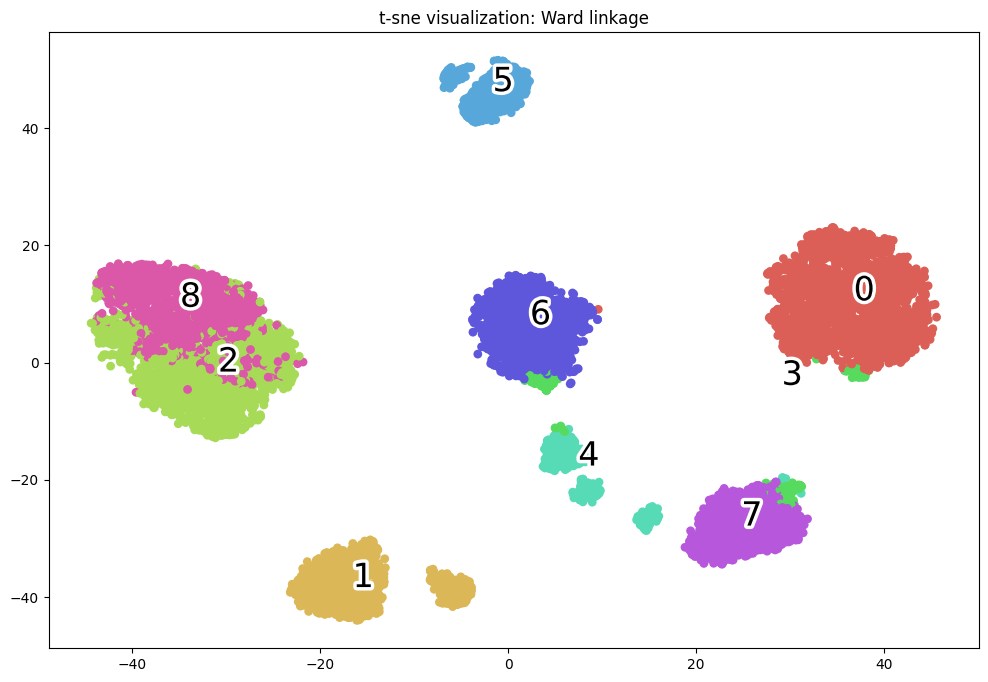

In [54]:
# Vẽ các đồ thị biểu diễn sự phân cụm theo từng phương pháp đo khoảng cách

def _plot_kmean_scatter(X, labels, title):
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(int)])
    txts = []
    for i in range(num_classes):
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization: '+title)    

_plot_kmean_scatter(players_tsne, labels_com, "Complete linkage")
_plot_kmean_scatter(players_tsne, labels_sing, "Single linkage")
_plot_kmean_scatter(players_tsne, labels_aver, "Average linkage ")
_plot_kmean_scatter(players_tsne, labels_ward, "Ward linkage")

``Nhận xét``:
- 3 phương pháp biểu diễn phân cấp **complete linkage, average linkage, ward linkage** đều thể hiện được sự phân cấp dữ liệu
- Phương pháp **Complete linkage** và **Single linkage** (tính khoảng cách của cặp điểm xa nhất và gần nhất) tạo ra cụm có hình dạng trải dài ảnh hưởng của việc tính khoảng cách của cụm theo cặp điểm xa nhất hoặc gần nhất. Vì vậy 2 phương pháp này sẽ bị ảnh hưởng nhiều bởi các ngoại lệ, và tạo ra cụm trải dài khiến cho đặc trưng giữa các cụm không quá rõ ràng.
- Phương pháp **Group average** lấy trung bình toàn bộ khoảng cách giữa các điểm. Vì vậy nó sẽ khá giống với 2 phương pháp **Complete linkage** và **Single linkage**
- Phương pháp **Ward linkage** là phương pháp phương sai nội cụm tối thiểu (minimum variance). Nó nhằm giảm thiểu phương sai bên trong các cụm, do đó tạo ra các cụm có hình dạng gần với hình cầu và kích thước tương đương nhau. Từ đó sẽ dễ quan sát, khảo sát được tính chất các cụm tốt hơn.
- **Do đó sẽ chọn phương pháp Ward linkage để sử dụng**

#### ``Khảo sát tính chất từng cụm``

In [55]:
# Gán nhãn cụm cho dữ liệu ban đầu 

players_with_labels = players_origin.copy()
players_with_labels['cluster'] = labels_ward

In [56]:
players_with_labels['cluster'].value_counts()

cluster
0    2553
2    1843
6    1520
8    1515
1    1353
7    1211
5     789
4     620
3     247
Name: count, dtype: int64

In [57]:
players_with_labels.head(3)

market_value  age  height  preferred_foot  position  attacking  technical  \
0          7400   22     189               1         1         68         55   
1          2500   25     179               2         1         62         48   
2          1200   22     184               2         1         64         51   

   tactical  defending  creativity  saves  anticipation  ball_distribution  \
0        51         33          49      0             0                  0   
1        54         32          47      0             0                  0   
2        45         29          48      0             0                  0   

   aerial  avg_score_last_12_months  appearances_last_12_months  \
0       0                      7.14                          33   
1       0                      6.86                          37   
2       0                      6.80                          34   

   point_of_tournament  cluster  
0               1858.0        4  
1               1858.0        6  
2               1858.0        6

In [58]:
# Chuyển ngược từ giá trị mã hóa về giá trị ban đầu

players_original_with_labels = players_with_labels.copy()

decoded_position_values = label_position_encoder.inverse_transform(players_with_labels['position'])
players_original_with_labels['position'] = decoded_position_values

decoded_foot_values = label_foot_encoder.inverse_transform(players_with_labels['preferred_foot'])
players_original_with_labels['preferred_foot'] = decoded_foot_values

In [59]:
# Tạo các players theo cụm

player_cluster_0 = players_original_with_labels[players_original_with_labels['cluster'] == 0]
player_cluster_1 = players_original_with_labels[players_original_with_labels['cluster'] == 1]
player_cluster_2 = players_original_with_labels[players_original_with_labels['cluster'] == 2]
player_cluster_3 = players_original_with_labels[players_original_with_labels['cluster'] == 3]
player_cluster_4 = players_original_with_labels[players_original_with_labels['cluster'] == 4]
player_cluster_5 = players_original_with_labels[players_original_with_labels['cluster'] == 5]
player_cluster_6 = players_original_with_labels[players_original_with_labels['cluster'] == 6]
player_cluster_7 = players_original_with_labels[players_original_with_labels['cluster'] == 7]
player_cluster_8 = players_original_with_labels[players_original_with_labels['cluster'] == 8]

In [60]:
# Dữ liệu cho các cluster
clusters = [player_cluster_0, player_cluster_1, player_cluster_2, player_cluster_3, player_cluster_4, 
            player_cluster_5, player_cluster_6, player_cluster_7, player_cluster_8]
# Dữ liệu cho các cluster độ cao
clusters_height = [player_cluster_0['height'], player_cluster_1['height'], player_cluster_2['height'], 
                   player_cluster_3['height'], player_cluster_4['height'], player_cluster_5['height'], 
                   player_cluster_6['height'], player_cluster_7['height'], player_cluster_8['height']]
# Dữ liệu cho các cluster độ tuổi
clusters_age = [player_cluster_0['age'], player_cluster_1['age'], player_cluster_2['age'], 
                   player_cluster_3['age'], player_cluster_4['age'], player_cluster_5['age'], 
                   player_cluster_6['age'], player_cluster_7['age'], player_cluster_8['age']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_scores = [player_cluster_0['avg_score_last_12_months'], player_cluster_1['avg_score_last_12_months'], player_cluster_2['avg_score_last_12_months'], 
                   player_cluster_3['avg_score_last_12_months'], player_cluster_4['avg_score_last_12_months'], player_cluster_5['avg_score_last_12_months'], 
                   player_cluster_6['avg_score_last_12_months'], player_cluster_7['avg_score_last_12_months'], player_cluster_8['avg_score_last_12_months']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_marketvalue = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                        player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                        player_cluster_6['market_value'], player_cluster_7['market_value'], player_cluster_8['market_value']]
# Dữ liệu cho các cluster số lần xuất hiện
clusters_appearances_last_12_months = [player_cluster_0['appearances_last_12_months'], player_cluster_1['appearances_last_12_months'], player_cluster_2['appearances_last_12_months'], 
                   player_cluster_3['appearances_last_12_months'], player_cluster_4['appearances_last_12_months'], player_cluster_5['appearances_last_12_months'], 
                   player_cluster_6['appearances_last_12_months'], player_cluster_7['appearances_last_12_months'], player_cluster_8['appearances_last_12_months']]
# Dữ liệu cho các cluster: giá trị thị trường 
clusters_market_value = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                   player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                   player_cluster_6['market_value'], player_cluster_7['market_value'], player_cluster_8['market_value']]
# Dữ liệu cho các cluster : các chỉ số
clusters_attacking = [player_cluster_0['attacking'], player_cluster_1['attacking'], player_cluster_2['attacking'], 
                   player_cluster_3['attacking'], player_cluster_4['attacking'], player_cluster_5['attacking'], 
                   player_cluster_6['attacking'], player_cluster_7['attacking'], player_cluster_8['attacking']]
clusters_technical = [player_cluster_0['technical'], player_cluster_1['technical'], player_cluster_2['technical'], 
                   player_cluster_3['technical'], player_cluster_4['technical'], player_cluster_5['technical'], 
                   player_cluster_6['technical'], player_cluster_7['technical'], player_cluster_8['technical']]
clusters_tactical = [player_cluster_0['tactical'], player_cluster_1['tactical'], player_cluster_2['tactical'], 
                   player_cluster_3['tactical'], player_cluster_4['tactical'], player_cluster_5['tactical'], 
                   player_cluster_6['tactical'], player_cluster_7['tactical'], player_cluster_8['tactical']]
clusters_defending = [player_cluster_0['defending'], player_cluster_1['defending'], player_cluster_2['defending'], 
                   player_cluster_3['defending'], player_cluster_4['defending'], player_cluster_5['defending'], 
                   player_cluster_6['defending'], player_cluster_7['defending'], player_cluster_8['defending']]
clusters_creativity = [player_cluster_0['creativity'], player_cluster_1['creativity'], player_cluster_2['creativity'], 
                   player_cluster_3['creativity'], player_cluster_4['creativity'], player_cluster_5['creativity'], 
                   player_cluster_6['creativity'], player_cluster_7['creativity'], player_cluster_8['creativity']]
clusters_saves = [player_cluster_0['saves'], player_cluster_1['saves'], player_cluster_2['saves'], 
                   player_cluster_3['saves'], player_cluster_4['saves'], player_cluster_5['saves'], 
                   player_cluster_6['saves'], player_cluster_7['saves'], player_cluster_8['saves']]
clusters_anticipation = [player_cluster_0['anticipation'], player_cluster_1['anticipation'], player_cluster_2['anticipation'], 
                   player_cluster_3['anticipation'], player_cluster_4['anticipation'], player_cluster_5['anticipation'], 
                   player_cluster_6['anticipation'], player_cluster_7['anticipation'], player_cluster_8['anticipation']]
clusters_ball_distribution = [player_cluster_0['ball_distribution'], player_cluster_1['ball_distribution'], player_cluster_2['ball_distribution'], 
                   player_cluster_3['ball_distribution'], player_cluster_4['ball_distribution'], player_cluster_5['ball_distribution'], 
                   player_cluster_6['ball_distribution'], player_cluster_7['ball_distribution'], player_cluster_8['ball_distribution']]
clusters_aerial = [player_cluster_0['aerial'], player_cluster_1['aerial'], player_cluster_2['aerial'], 
                   player_cluster_3['aerial'], player_cluster_4['aerial'], player_cluster_5['aerial'], 
                   player_cluster_6['aerial'], player_cluster_7['aerial'], player_cluster_8['aerial']]
clusters_point_of_tournament = [player_cluster_0['point_of_tournament'], player_cluster_1['point_of_tournament'], player_cluster_2['point_of_tournament'], 
                   player_cluster_3['point_of_tournament'], player_cluster_4['point_of_tournament'], player_cluster_5['point_of_tournament'], 
                   player_cluster_6['point_of_tournament'], player_cluster_7['point_of_tournament'], player_cluster_8['point_of_tournament']]
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# Màu sắc cho các boxplot của từng cluster độ cao
box_colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightyellow', 'lightblue', 'lightgreen', 'lightcoral']

``Khảo sát các vị trí đá của cầu thủ trong các cụm``

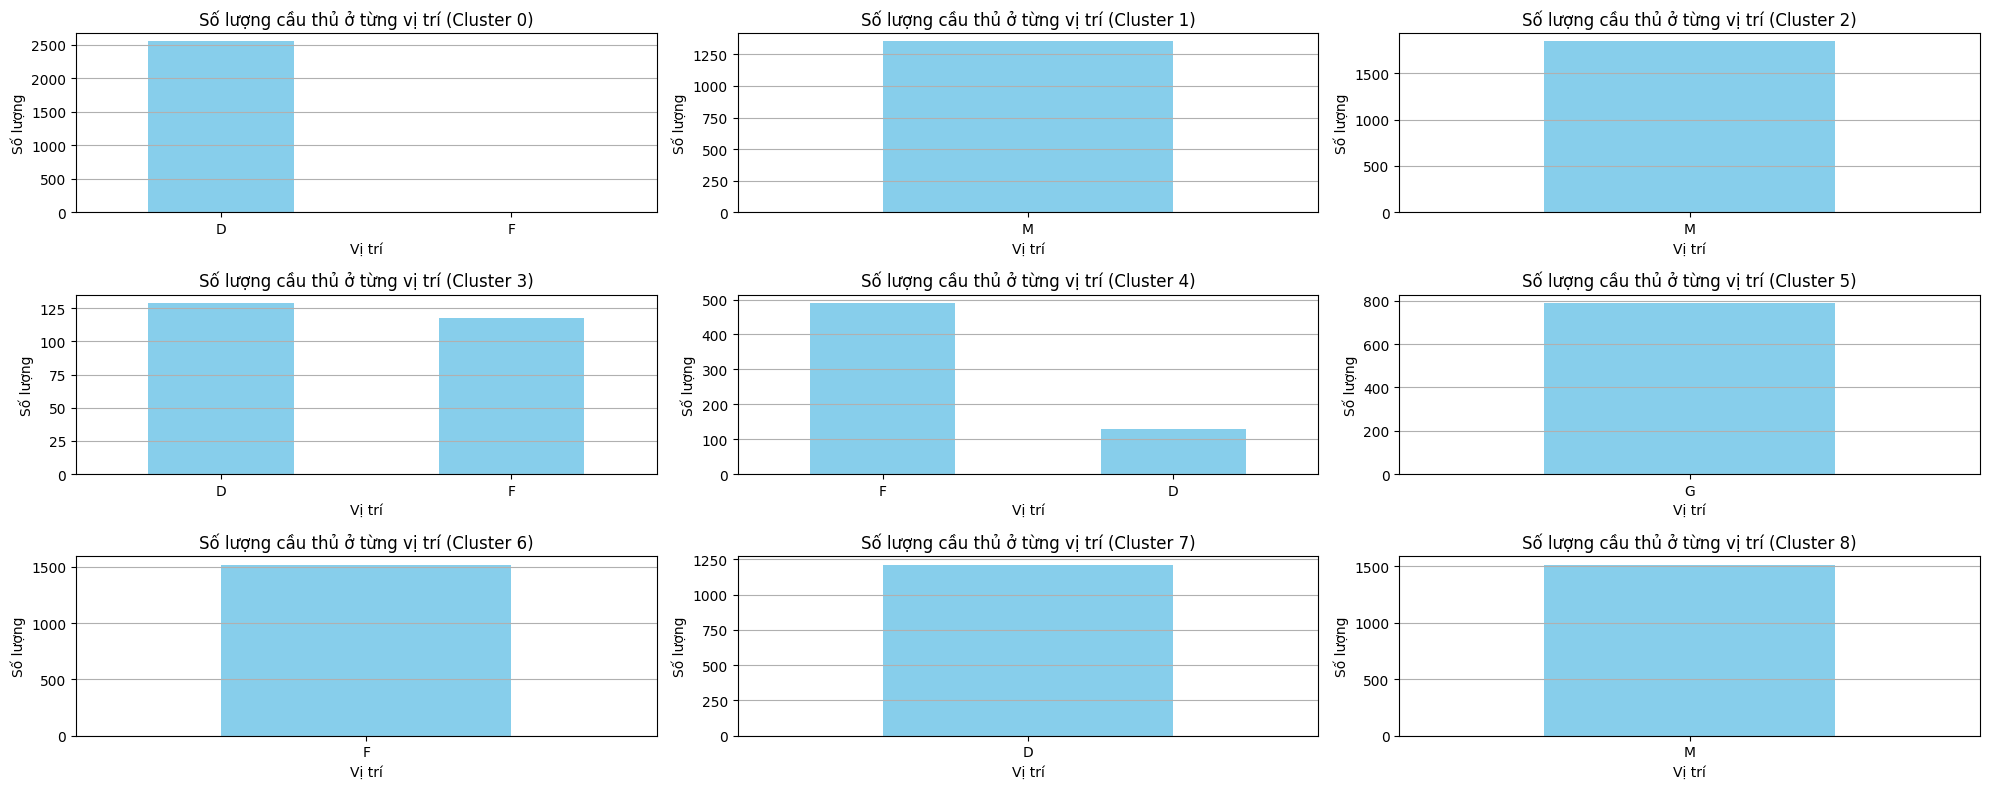

In [61]:
# Khảo sát vị trí đá trong các cụm

plt.figure(figsize=(20, 8))
for i, cluster_data in enumerate(clusters):
    positions = cluster_data['position']
    position_counts = positions.value_counts()
    plt.subplot(3, 3, i+1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Cụm 0 và 7: có duy nhất vị trí cầu thủ là Hậu về(D)
- Cụm 1, 2 và 8: có duy nhất vị trí cầu thủ là Tiền vệ(M)
- Cụm 5: có duy nhất vị trí cầu thù là Thủ môn(G)
- Cụm 6: có duy nhất vị trí cầu thủ là Tiền đạo(F)
- Cụm 3 và 4: có 2 vị trí cầu thù là Tiền đạo(F) và Hậu về(D). Trong đó, Cụm 3 có nhiều Hậu về(D) hơn trong khi Cụm 4 phần lớn là Tiền đạo(F)

``Khảo sát theo (độ tuổi, chiều cao, điểm số trung bình và số lần xuất hiện 12 tháng gần nhất, hệ số giải đấu)``

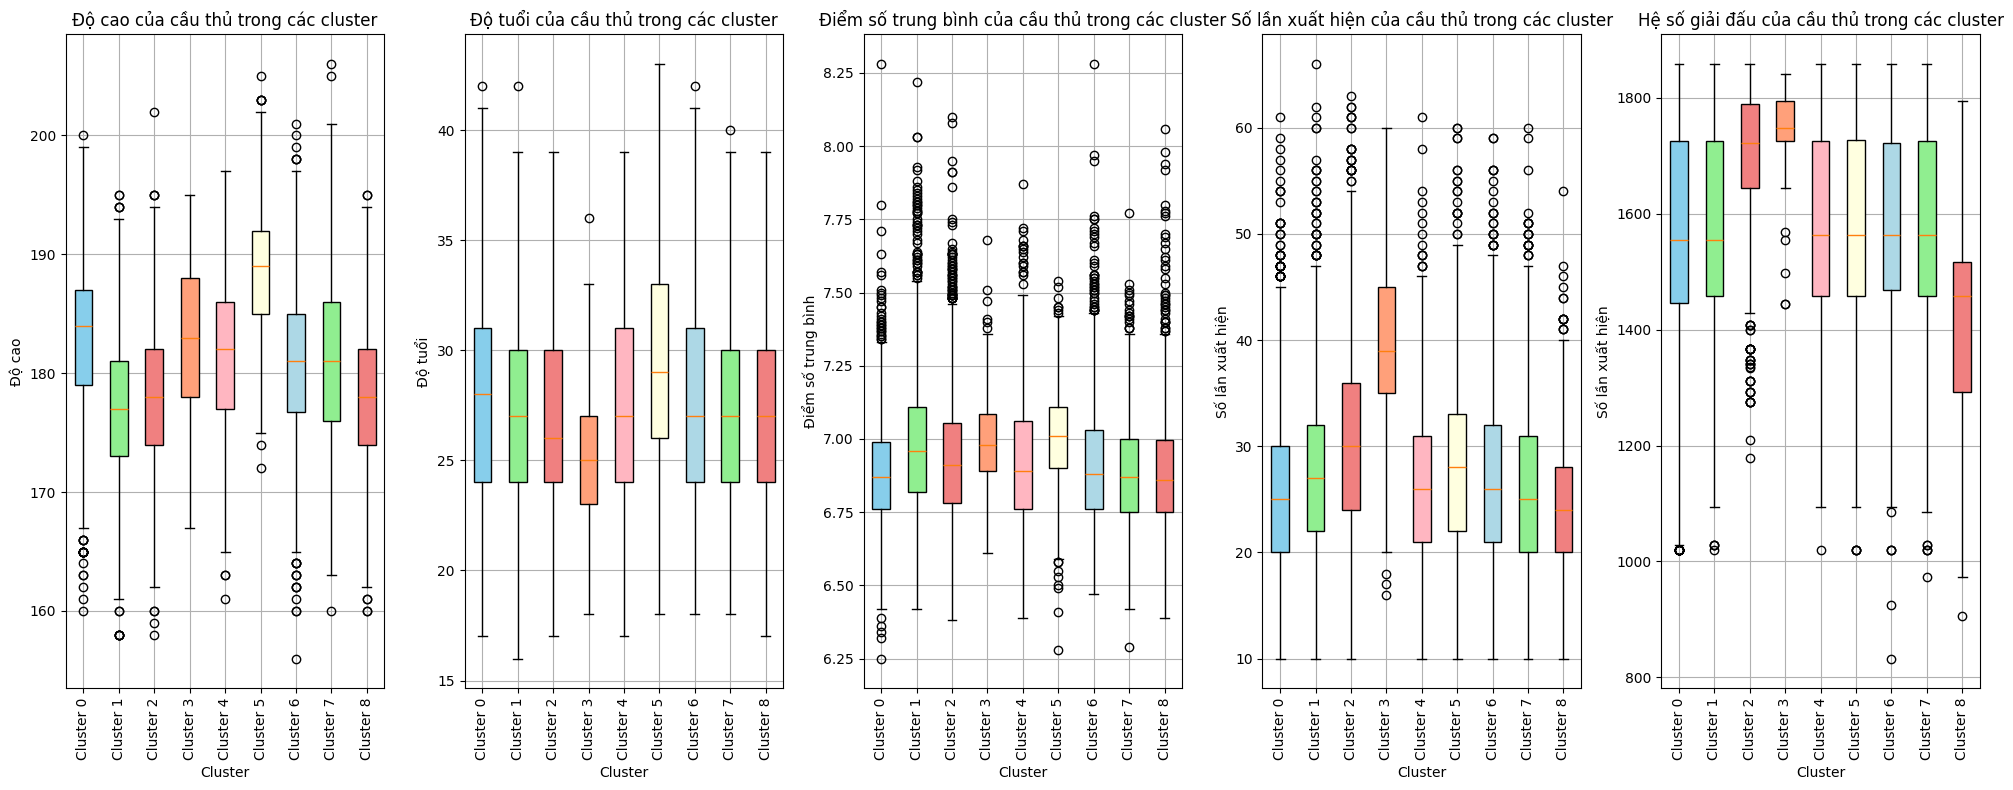

In [62]:
plt.figure(figsize=(20, 8))
# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()

#     plt.subplot(3, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ cao
plt.subplot(1, 5, 1)
boxplot_height = plt.boxplot(clusters_height, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ cao của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ cao')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ tuôi
plt.subplot(1, 5, 2)
boxplot_height = plt.boxplot(clusters_age, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ tuổi của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ tuổi')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho điểm số trung bình
plt.subplot(1, 5, 3)
boxplot_scores = plt.boxplot(clusters_scores, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 
        'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_scores['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Điểm số trung bình của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Điểm số trung bình')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho số lần xuất hiện
plt.subplot(1, 5, 4)
boxplot_height = plt.boxplot(clusters_appearances_last_12_months, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Số lần xuất hiện của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho hệ số giải đấu
plt.subplot(1, 5, 5)
boxplot_height = plt.boxplot(clusters_point_of_tournament, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Hệ số giải đấu của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Hậu về (D): Hậu vệ trong cụm 0, 3, 4 và 7 có các thông số khá tương đồng nhau.
- Cụm về Tiền đạo(F): Tiền đạo trong các cụm 3, 4 và 6 có các thông số khá tương đồng nhau.
    + Đặc biệt,  Tiền đạo và Hậu về trong cụm 3 là các Hậu về trẻ, được ra sân nhiều hơn và thường được đá trong các giải có hệ số cao hơn các Tiền đạo, Hậu vệ trong các cụm còn lại.
- Các cụm về Tiền vệ(M): 
    + Tiền vệ trong các cụm 1, 2 và 8 có các chỉ số khá tương đồng nhau
    + Khác biệt là tiền vệ trong cụm 1, 2 là các tiền vệ thi đấu trong các giải lớn và tần suất ra sân cao, Tiền vệ trong cụm 8 là các giải hệ số nhỏ và không thường xuyên ra sân
- Cụm về Thủ môn(G): Cụm 5 là cụm chỉ riêng Thủ môn mang rõ đặc trưng của vai trò thủ môn khi có Chiều cao và độ tuổi trung bình lơn

``Khảo sát theo các chỉ số (9 chỉ số)``

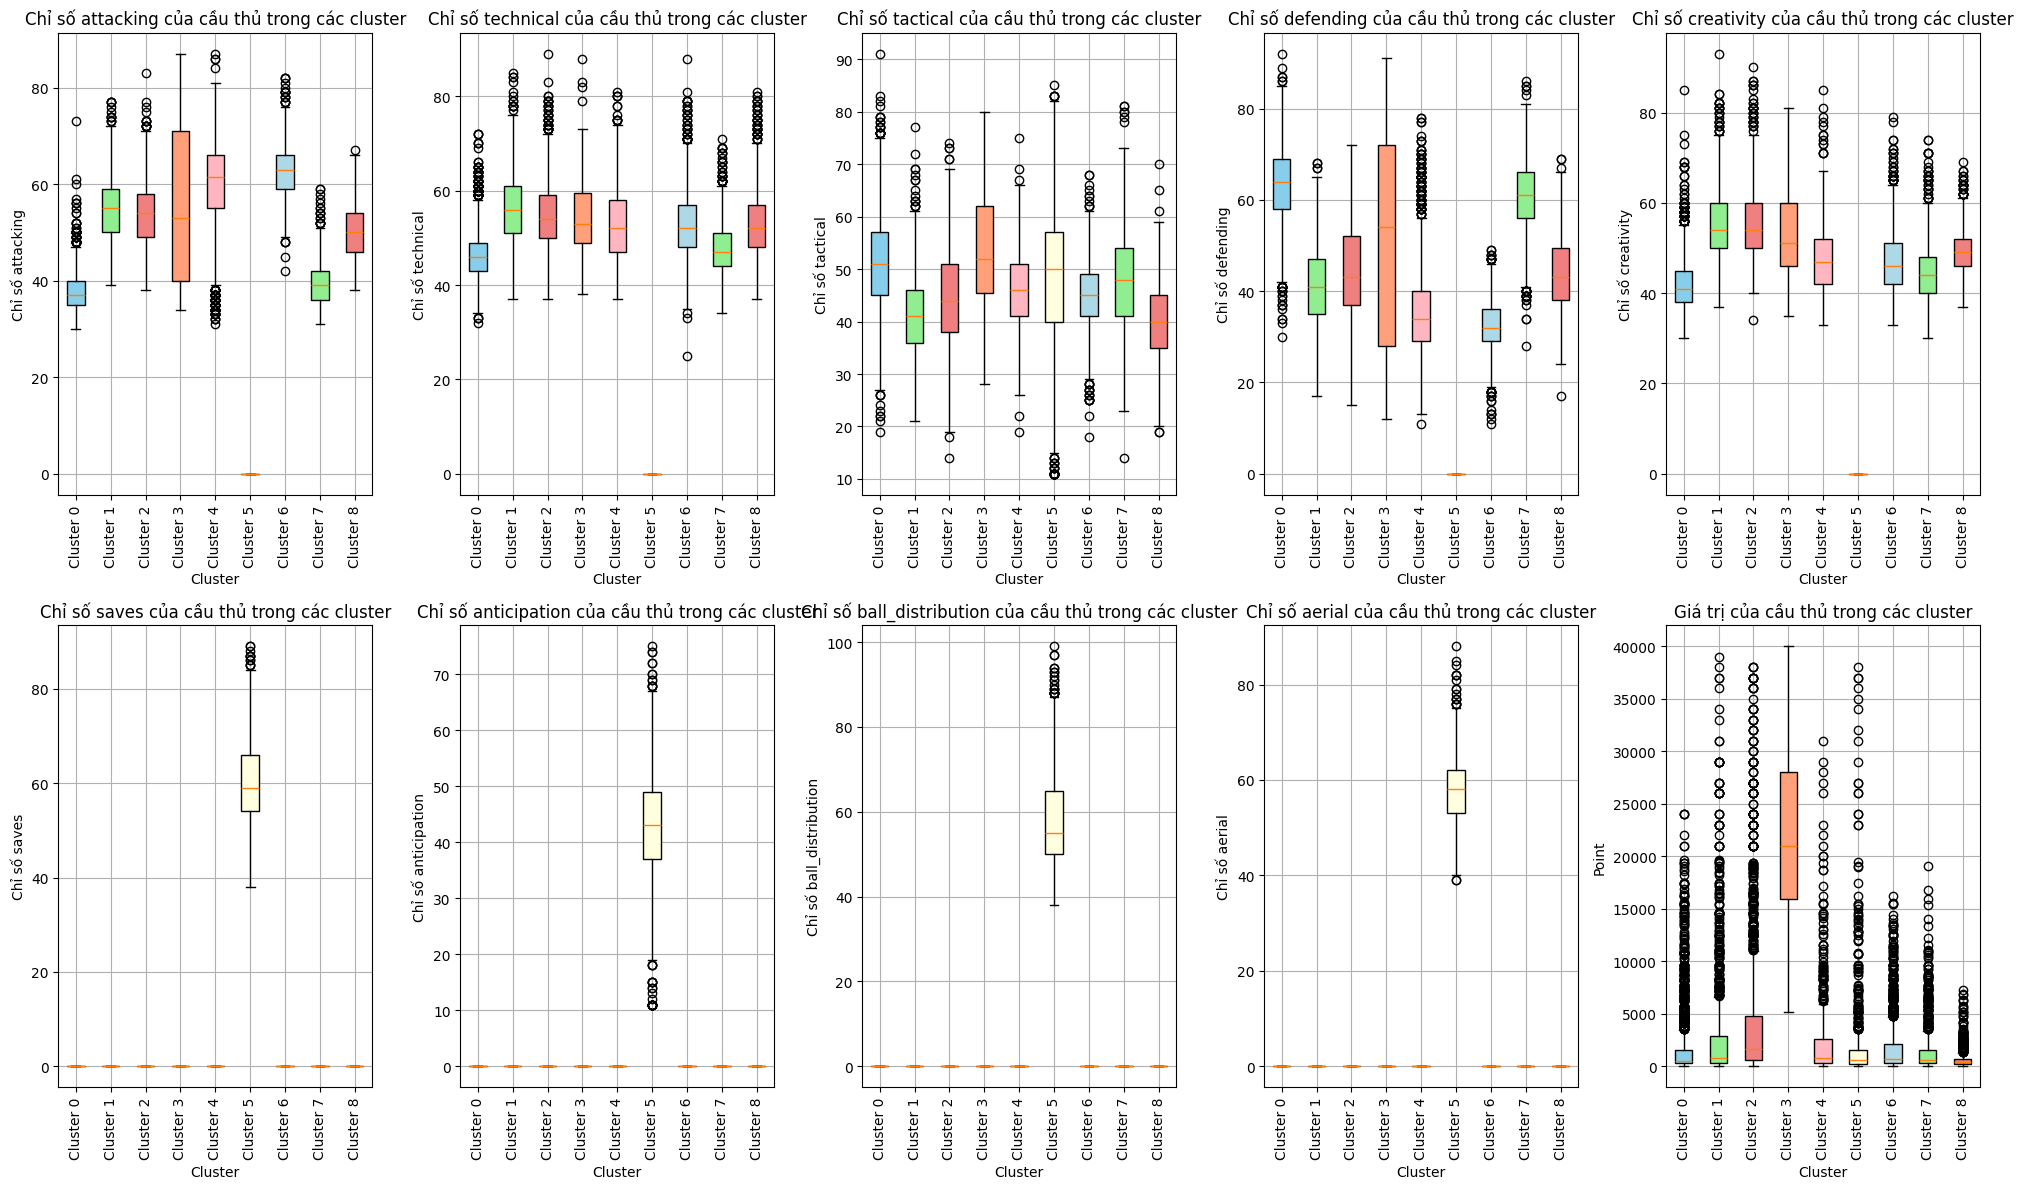

In [63]:
plt.figure(figsize=(20, 12))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()
#     plt.subplot(4, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho attacking
plt.subplot(2, 5, 1)
boxplot_height = plt.boxplot(clusters_attacking, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số attacking của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số attacking')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho technical
plt.subplot(2, 5, 2)
boxplot_height = plt.boxplot(clusters_technical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số technical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số technical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho tactical
plt.subplot(2, 5, 3)
boxplot_height = plt.boxplot(clusters_tactical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số tactical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số tactical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho defending
plt.subplot(2, 5, 4)
boxplot_height = plt.boxplot(clusters_defending, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số defending của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số defending')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho creativity
plt.subplot(2, 5, 5)
boxplot_height = plt.boxplot(clusters_creativity, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số creativity của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số creativity')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho saves
plt.subplot(2, 5, 6)
boxplot_height = plt.boxplot(clusters_saves, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số saves của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số saves')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho anticipation
plt.subplot(2, 5, 7)
boxplot_height = plt.boxplot(clusters_anticipation, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số anticipation của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số anticipation')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho ball_distribution
plt.subplot(2, 5, 8)
boxplot_height = plt.boxplot(clusters_ball_distribution, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số ball_distribution của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số ball_distribution')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho aerial
plt.subplot(2, 5, 9)
boxplot_height = plt.boxplot(clusters_aerial, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số aerial của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số aerial')
plt.xticks(rotation=90)
plt.grid(True)
# -----------------------------------------------------------------
# Biểu đồ boxplot cho market value
plt.subplot(2, 5, 10)
boxplot_height = plt.boxplot(clusters_market_value, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Giá trị của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Point')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()

**Nhận xét:**
- Các cụm về Hậu về (D):
    + Hậu vệ trong cụm 0 và 7 có các chỉ số khá tương đồng nhau, đều có chỉ số Defending và Tactical cao và chỉ số về Attacking, Technical, Creativity thấp. Tuy nhiên, Cụm 0 nổi bật hơn về khả năng phòng thủ, chiến thuật. Trong khi Cụm 7 lại mạnh hơn về khả năng Tấn công, kỹ thuật và sáng tạo.
- Cụm về Tiền đạo(F): Tiền đạo trong cụm 6 có các chỉ số đều ở mức thấp.
    + Đặc biệt, Tiền đạo và Hậu về ở cụm 3, 4 mạnh về chỉ số Attacking, Technical, Creativity. Riêng cầu thủ cụm 3 cũng mạnh về chỉ số Tactical và Defending từ đó thấy được sự toàn diện về chỉ số của cụm 3.
- Các cụm về Tiền vệ(M): Tiền vệ trong cụm 1, 2 có chỉ số Attacking, Technical và Creativity khá cao, tuy nhiên Cụm 1 có phần nhỉnh hơn đôi chút trong khi Cụm 2 lại lớn về về chỉ số Tactical và Defending, Tiền vệ trong cụm 8 có chỉ số thấp
- Cụm về Thủ môn(G): Cụm 5, thủ môn là nhóm có Tactical cao, sự chỉ số giữa các thủ môn trong cụm là không quá tách biệt

``Khảo sát theo chân đá``

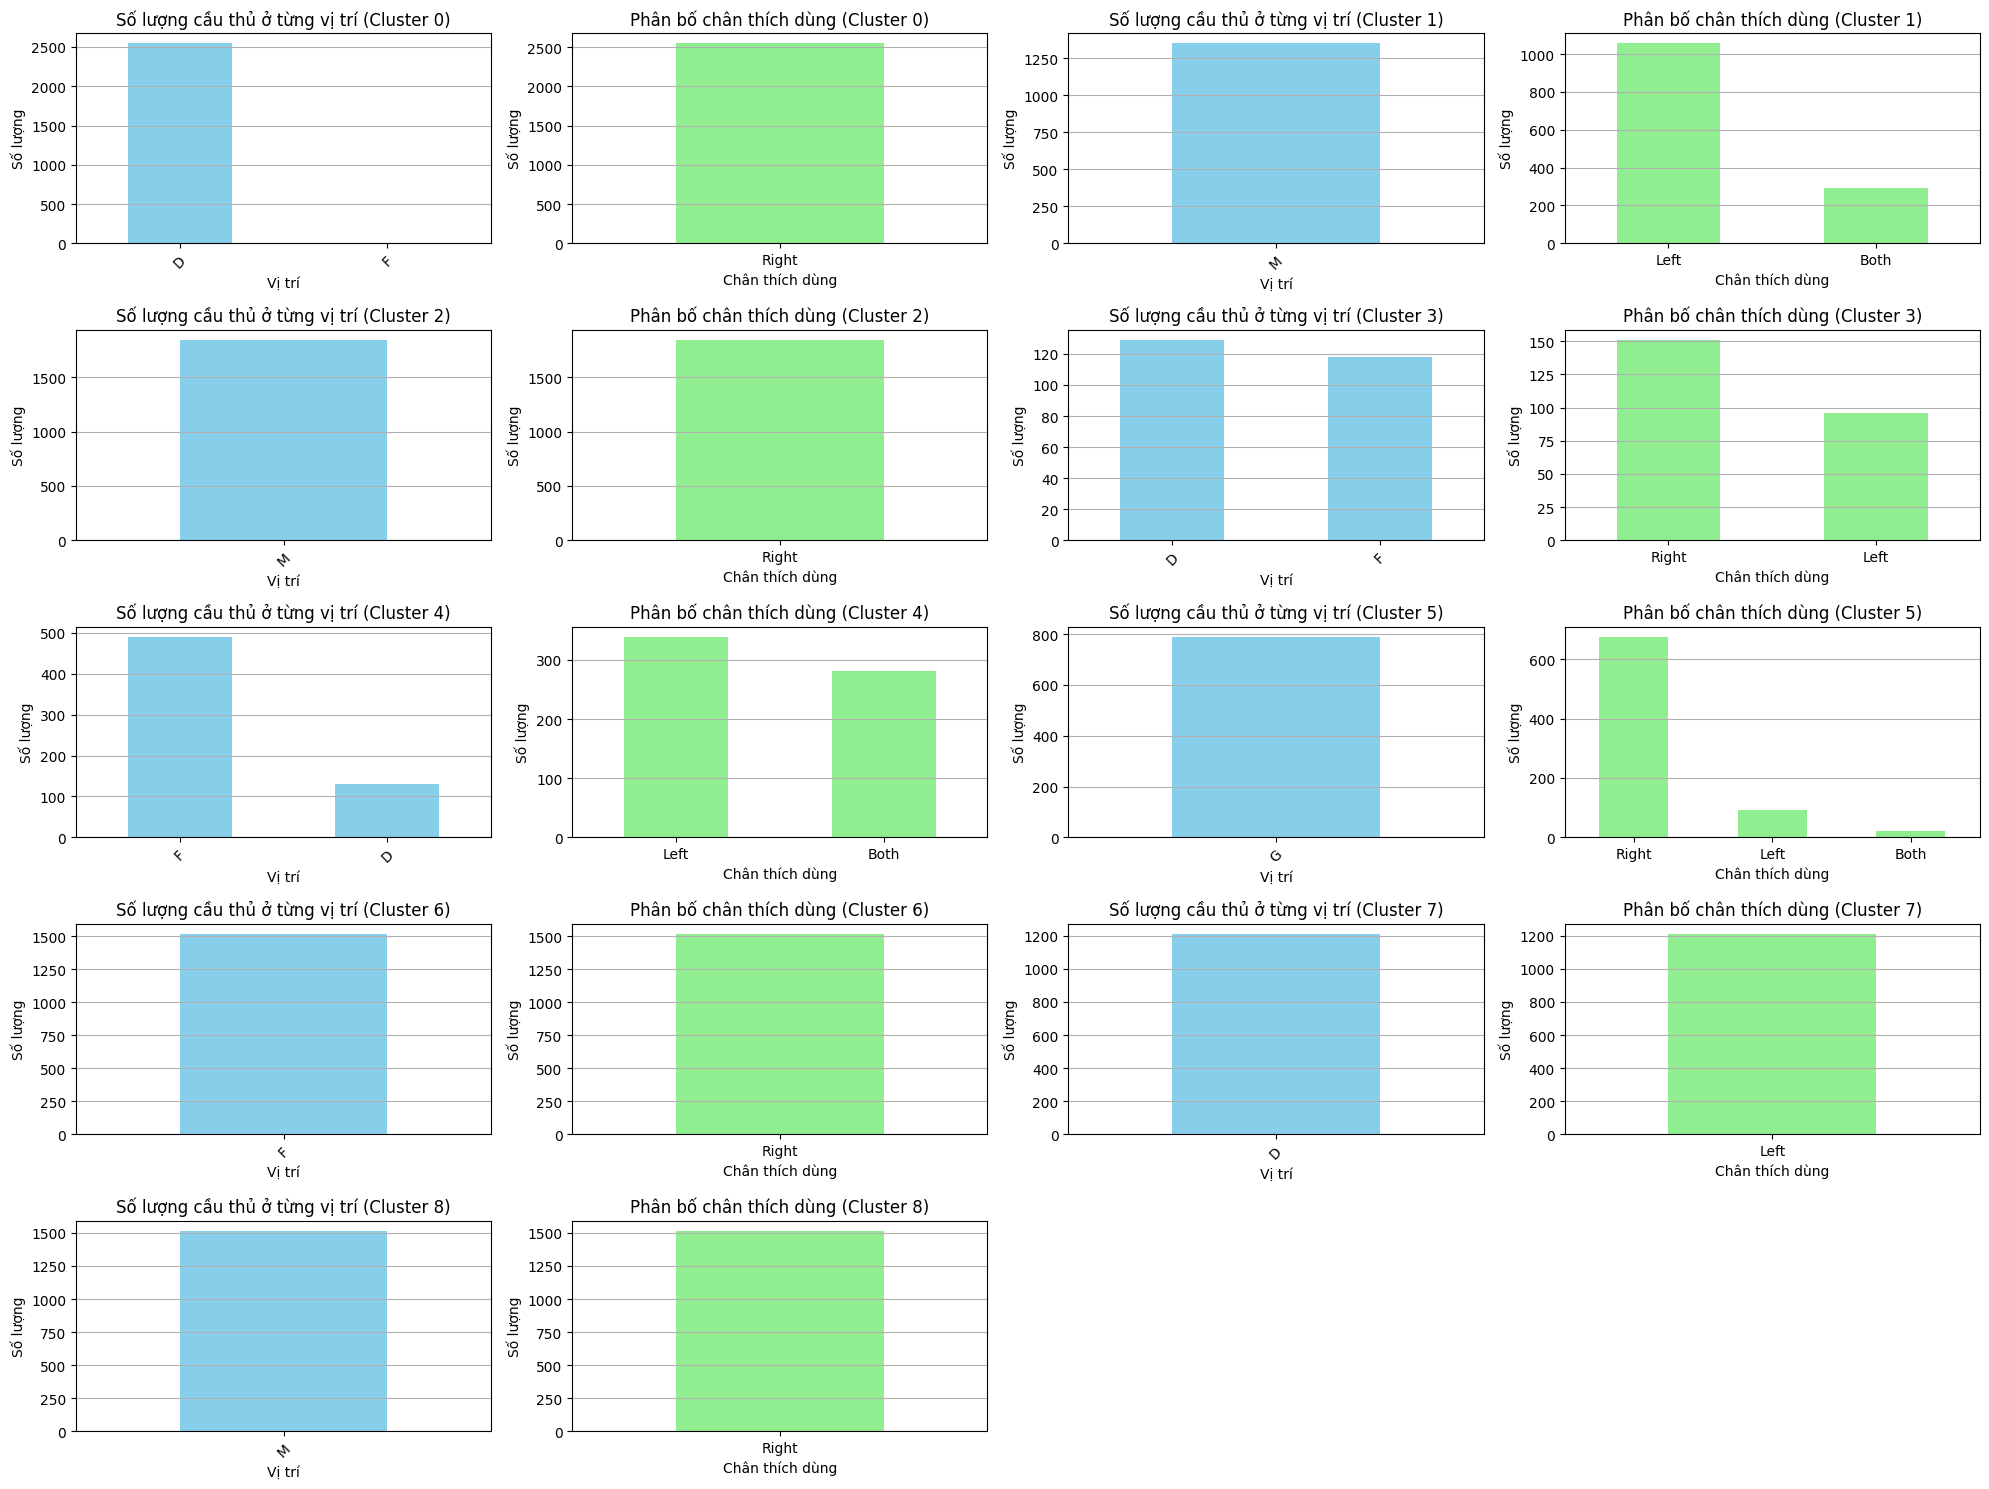

In [64]:
# Khảo sát chân thuận các cầu thủ trong các cụm

plt.figure(figsize=(20, 15))

for i, cluster_data in enumerate(clusters):
    positions = cluster_data['position']
    preferred_foot = cluster_data['preferred_foot']
    position_counts = positions.value_counts()
    foot_counts = preferred_foot.value_counts()

    # Biểu đồ số lượng cầu thủ ở từng vị trí
    plt.subplot(5, 4, (2 * i) + 1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Biểu đồ phân bố chân thích dùng
    plt.subplot(5, 4, (2 * i) + 2)
    foot_counts.plot(kind='bar', color='lightgreen')
    plt.title(f'Phân bố chân thích dùng (Cluster {i})')
    plt.xlabel('Chân thích dùng')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Các cụm về Hậu về (D):
    + Hậu vệ trong cụm 0 sở trường đá chân Phải.
    + Hậu vệ trong cụm 7 sở trường đá chân Trái.
    + Hậu vệ trong cụm 3 sở trường đá cả chân trái hoặc phải. Tuy nhiên, hậu vệ chân Phải nhiều hơn.
    + Hậu vệ trong cụm 4 có sở trường đá cả 2 chân. Tuy nhiên các cầu thủ chỉ thuận chân trái chiếm cao hơn.
- Cụm về Tiền đạo(F):
    + Tiền đạo trong cụm 6 sở trường đá chân Phải.
    + Tiền đạo cụm 3 có cùng đặc trưng với Hậu vệ cụm 3: sở trường đá chân Phải nhiều hơn.
    + Tiền đạo cụm 4 có nhiều cầu thủ chỉ thuận đá chân Trái hơn.
- Các cụm về Tiền vệ(M): 
    + Tiền vệ trong cụm 1 có sở trường là chân trái, vẫn có 1 số cầu thủ có thể đá cả 2 chân.
    + Tiền vệ trong cụm 2 và 8 sở trường đá chân Phải.
- Cụm về Thủ môn(G): Thủ môn hầu hết sở trường chân phải, số ít sở trường chân Trái và cả 2.

``Khảo sát theo giá trị thị trường``

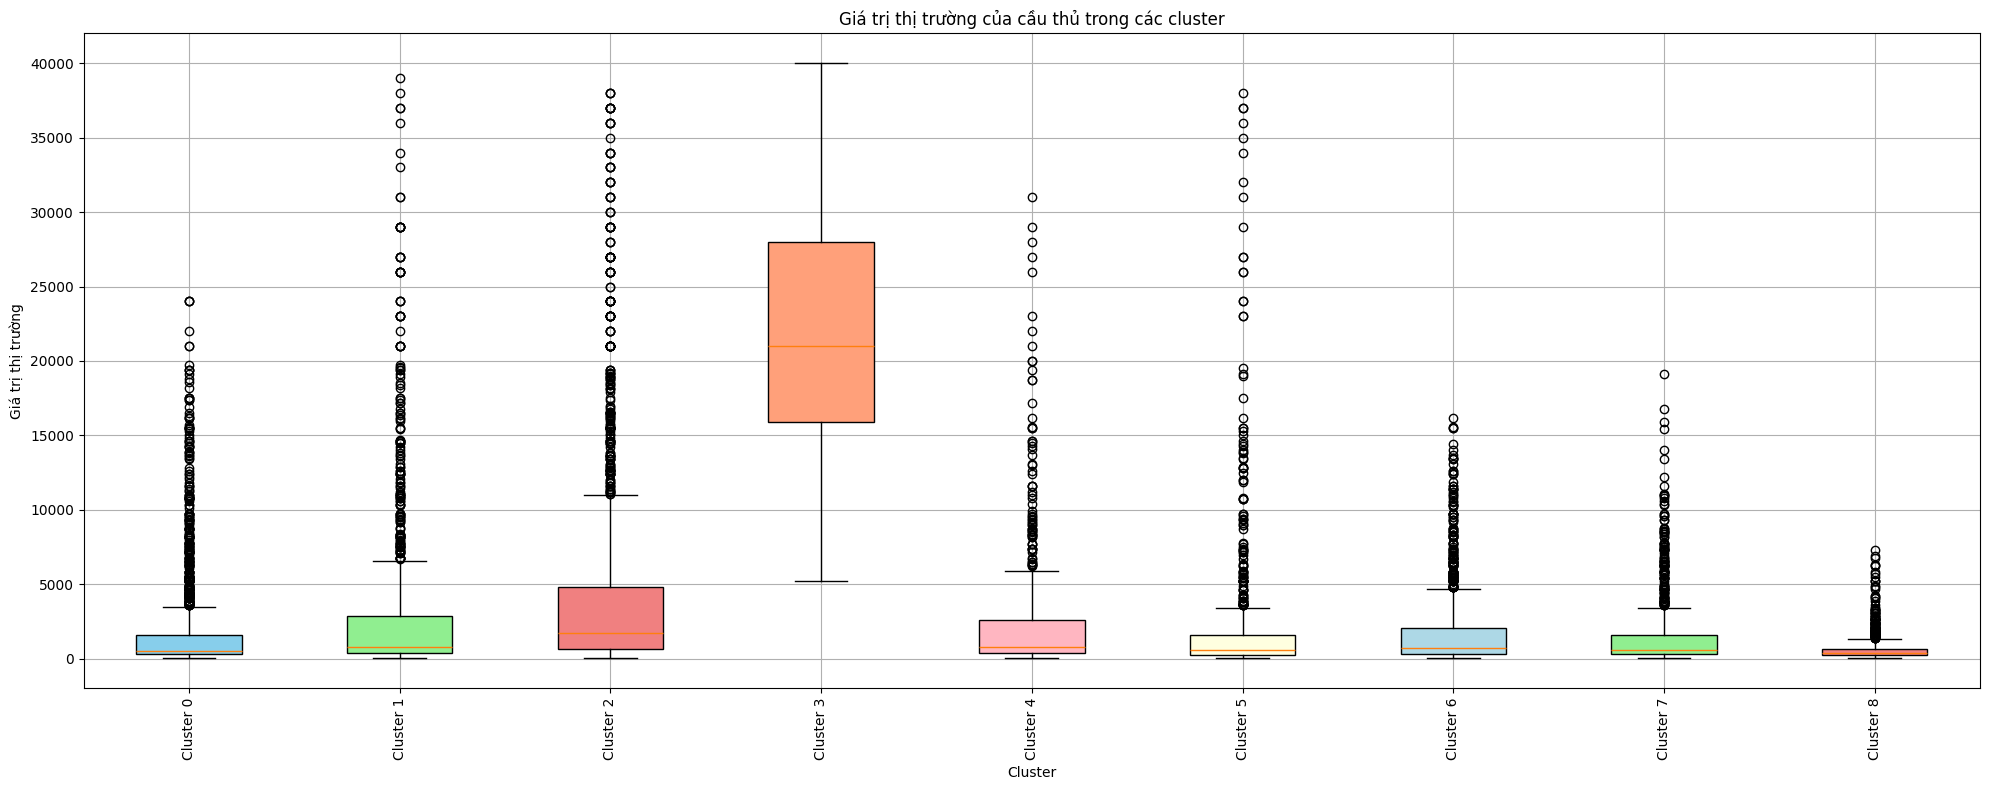

In [65]:
plt.figure(figsize=(20, 8))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()

#     plt.subplot(2, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho giá trị thị trường 
# plt.subplot(1, 1, 1)
boxplot_height = plt.boxplot(clusters_market_value, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Giá trị thị trường của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Giá trị thị trường')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Hậu về (D):
    + Hậu vệ cụm 3 với các chỉ số cao toàn diện có giá trị thị trường rất cao
    + Hậu vệ cụm 4 có giá trị ở mức trung bình cao
    + Hậu vệ ở cụm 0 và 7 có giá trị ở mức trung bình
- Cụm về Tiền đạo(F): 
    + Tiền đạo cụm 3 với các chỉ số cao toàn diện nên có giá trị thị trường rất cao.
    + Tiền đạo ở cụm 4 và 6 có giá trị trung bình cao
- Các cụm về Tiền vệ(M):
    + Tiền vệ ở cụm 1 và 2 có giá trị trung bình cao, tuy nhiên ở cụm 2 có giá trị cao vượt trội cụm 1
    + Tiền vệ cụm 8 có giá trị thấp
- Cụm về Thủ môn(G): Thủ môn có giá trị ở mức trung bình thấp

**``Nhận xét``**
- Phương pháp phân cụm phân cấp **Hierarchical Clustering** cho ra kết quả các cụm có tính chất và phân bố khác nhau tùy theo phương pháp đo khoảng cách giữa 2 cụm và lựa chọn thước đo về sự khác biệt giữa các cụm 
- **Hierarchical Clustering** cho ra kết quả phân cụm thể hiển tốt mỗi quan hệ giữa các cụm.
- Các cụm thu được:
    + Cụm 0: Là Hậu vệ, defending|tactical khá cao, attacking|technical|creativity thấp, chân phải, giá trị trung bình
    + Cụm 1: Là Tiền vệ, hay ra sân, giải đấu lớn, attacking|technical|creativity khá cao, defending|tactical trung bình, chân trái|số ít thuận 2 chân, giá trị trung bình cao
    + Cụm 2: Là Tiền vệ, hay ra sân, giải dấu lớn, attacking|technical|creativity trung bình, defending|tactical khá cao, chân phải, giá trị trung bình cao
    + Cụm 3: Là Tiền đạo/Hậu vệ, trẻ, hay ra sân, giải đấu lớn, chỉ số cao toàn diện, chân phải, giá trị cao
    + Cụm 4: Là Tiền đạo/Hậu vệ, attacking|technical|creativity cao, chân trái, giá trị trung bình cao
    + Cụm 5: Là Thủ môn, cao, lớn tuổi, tactical cao, chân phải|số ít chân trái hoặc cả 2 chân
    + Cụm 6: Là Tiền đạo, chỉ số thấp, chân phải, giá trị trung bình thấp
    + Cụm 7: Là Hậu vệ, defending|tactical trung bình, attacking|technical|creativity khá cao, chân trái, giá trị trung bình
    + Cụm 8: Là Tiền vệ, ít ra sân, giải đấu nhỏ, chỉ số thấp, chân phải, giá trị thấp

### ``B. DBSCAN``: kĩ thuật phân cụm dựa trên mật độ (Density-Based Clustering)

Cốt lõi phương pháp:
- Phương pháp học không giám sát nhằm xác định các cụm phân biệt trong phân phối của dữ liệu
- Ý tưởng: một cụm trong không gian dữ liệu là một vùng có mật độ điểm cao được ngăn cách với các cụm khác bằng các vùng liền kề có mật độ điểm thấp.
- DBSCAN là một thuật toán cơ sở để phân nhóm dựa trên mật độ. Nó có thể phát hiện ra các cụm có hình dạng và kích thước khác nhau từ một lượng lớn dữ liệu chứa nhiễu.

##### ``Ưu điểm``
- Phân cụm theo mật độ (bỏ qua các outlier, không làm biến dạng cụm)
- Tìm được các điểm không thuộc bất kỳ cụm nào
- Không cần biết trước số cụm
##### ``Nhược điểm``
- Phải tìm đc epsilon
- Không phù hợp với bài toán mà kiểu dữ liệu thưa thớt hay tập dữ liệu phân bố không đồng đều

##### ``Các định nghĩa, tham số chính``
- Epsilon: là giá trị khoảng cách được sử dụng để xác định vùng lân cận epsilon của bất kỳ điểm dữ liệu nào. Giá trị của epsilon được chọn bằng biểu đồ k-distance, epsilon đạt giá trị tốt nhất tại elbow point.
- MinPts: Là số điểm tối thiểu để nhóm lại với nhau nhằm xác định vùng lân cận epsilon.
    + MinPts >= D + 1(D là số chiều của tập dữ liệu). Thường chọn min_points = 2 x D (nhiễu càng nhiều thì MinPts càng lớn)
##### ``Phân loại dạng điểm trong DBSCAN``
- Core point: là một điểm có ít nhất minPts trong vùng lân cận epsilon của nó.
- Border point: là một điểm có ít nhất một core point trong vùng lân cận epsilon nhưng mật độ không đủ minPts điểm.
- Noise point: là điểm không phải core point hay border point.
##### ``Thuật toán``
- Bước 1
    + Xác định các core point và border point của tập dữ liệu. 
- Bước 2:
    + Chọn ngẫu nhiên core point (không nằm trong cụm nào cả) gán vào 1 cụm.
    + Tìm các điểm lân cận của core point. 
        * Nếu điểm đó là core point thì thêm vào cụm, tiếp tục mở rộng cụm từ core point này. 
        * Nếu điểm đó là border point thì thêm vào cụm nhưng không mở rộng cụm từ điểm này  
- Bước 3:
    + Lặp lại đệ qui toàn bộ quá trình để xác định một cụm mới. 

### **``Áp dụng``**
--------

In [66]:
players = players_encoded

## Xác định các tham số

In [67]:
neighbors = 34

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

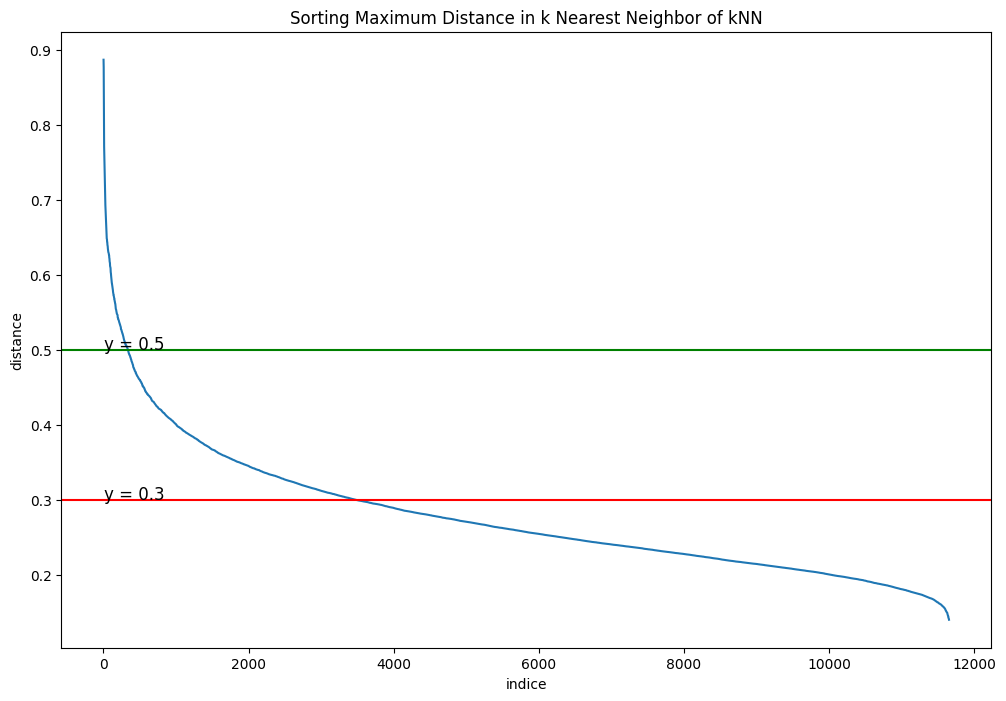

In [68]:
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(players)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(players)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.axhline(y=0.3,color='red')
plt.text(2, 0.3, 'y = 0.3',fontsize=12)
plt.axhline(y=0.5, color='green')
plt.text(2, 0.5, 'y = 0.5', fontsize=12)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

## Hàm plot kết quả phân cụm

In [69]:
def _plot_kmean_scatter(X, labels, gs, thres): 
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    ax = plt.subplot(gs)
    sc = ax.scatter(X[:,0], X[:,1], c=palette[labels.astype(np.int64)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        indices = (labels == i)
        xtext, ytext = np.median(X[indices, :], axis=0)
        if not (np.isnan(xtext) or np.isnan(ytext)):        
            txt = ax.text(xtext, ytext, str(i), fontsize=24) 
            txts.append(txt)
    plt.title('t-sne visualization for thres={:.4f}'.format(thres))

### Khảo sát các eps giúp xác định các điểm nằm trong vùng lân cận epsilon

10 10 11 10 10 10 10 10 9 9 9 9 

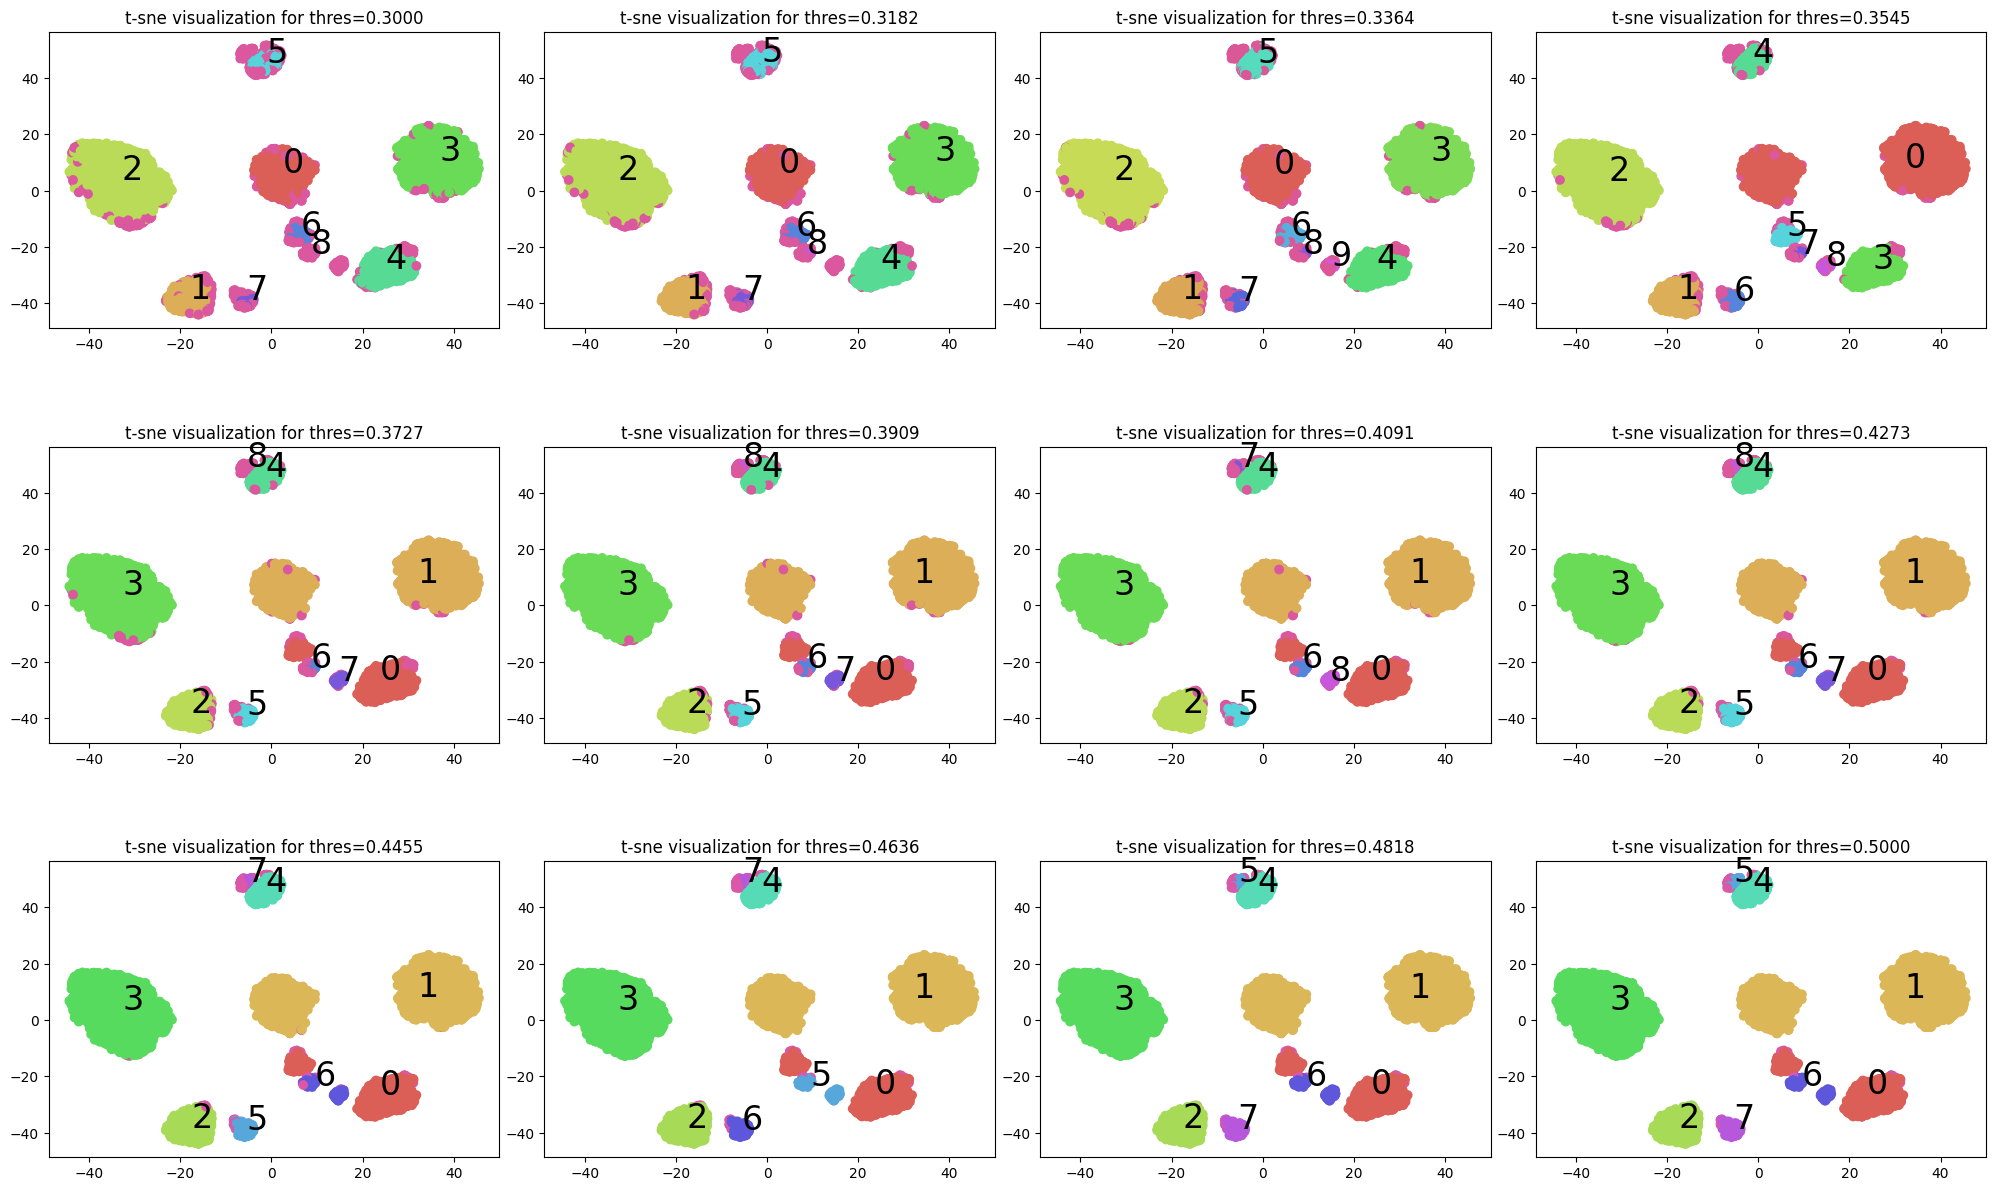

In [70]:
gs = GridSpec(4, 4) 
plt.figure(figsize = (25, 20))
plt.subplots_adjust(wspace=0.1,hspace=0.4)

for i, thres in enumerate(np.linspace(0.3, 0.5, 12)):
    dbscan = DBSCAN(eps=thres, min_samples=2*17+1, metric='euclidean')
    labels = dbscan.fit_predict(players) 
    print(len(np.unique(labels)),end=' ')
    _plot_kmean_scatter(players_tsne, labels, gs[i], thres) 

```Nhận xét```
- Giá trị eps = 0.4818 cho kết quả cụm rõ ràng và ít giá trị ngoại lệ không được phân cụm

In [71]:
dbscan = DBSCAN(eps=0.4818, min_samples=2*17+1)
labels = dbscan.fit_predict(players) 

Text(0.5, 1.0, 't-sne visualization for thres=0.5000')

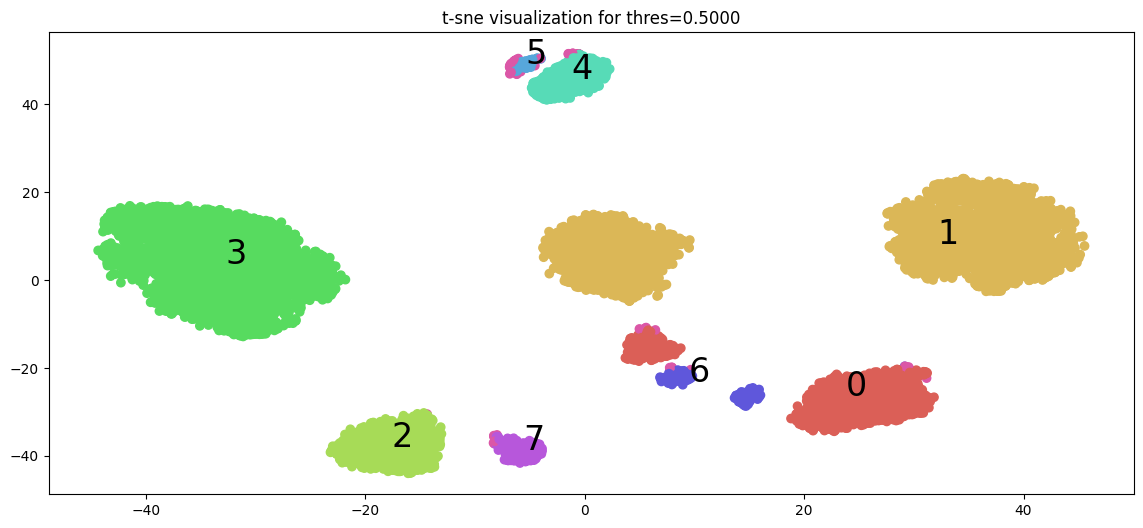

In [72]:
# px.scatter(x=players_tsne[:,0], y=players_tsne[:,1], color=labels)
num_classes = len(np.unique(labels))
palette = np.array(sns.color_palette("hls", num_classes))

ax = plt.subplot()
ax.scatter(players_tsne[:,0], players_tsne[:,1], c=palette[labels.astype(np.int64)])
txts = []
for i in range(num_classes):
    # Vẽ text tên cụm tại trung vị của mỗi cụm
    indices = (labels == i)
    xtext, ytext = np.median(players_tsne[indices, :], axis=0)
    if not (np.isnan(xtext) or np.isnan(ytext)):        
        txt = ax.text(xtext, ytext, str(i), fontsize=24) 
        txts.append(txt)
plt.title('t-sne visualization for thres={:.4f}'.format(thres))

In [73]:
players_with_labels = players_origin.copy()
players_with_labels['cluster'] = labels

In [74]:
players_with_labels['cluster'].value_counts()

cluster
 1    4224
 3    3358
 0    1641
 2    1058
 4     668
 7     285
 6     271
 5      79
-1      67
Name: count, dtype: int64

In [75]:
# Chuyển ngược từ giá trị mã hóa về giá trị ban đầu
players_original_with_labels = players_with_labels.copy()

decoded_position_values = label_position_encoder.inverse_transform(players_with_labels['position'])
players_original_with_labels['position'] = decoded_position_values

decoded_foot_values = label_foot_encoder.inverse_transform(players_with_labels['preferred_foot'])
players_original_with_labels['preferred_foot'] = decoded_foot_values

In [76]:
players_original_with_labels.head(3)

market_value  age  height preferred_foot position  attacking  technical  \
0          7400   22     189           Left        F         68         55   
1          2500   25     179          Right        F         62         48   
2          1200   22     184          Right        F         64         51   

   tactical  defending  creativity  saves  anticipation  ball_distribution  \
0        51         33          49      0             0                  0   
1        54         32          47      0             0                  0   
2        45         29          48      0             0                  0   

   aerial  avg_score_last_12_months  appearances_last_12_months  \
0       0                      7.14                          33   
1       0                      6.86                          37   
2       0                      6.80                          34   

   point_of_tournament  cluster  
0               1858.0        0  
1               1858.0        1  
2               1858.0        1

In [77]:
player_cluster_0 = players_original_with_labels[players_original_with_labels['cluster'] == 0]
player_cluster_1 = players_original_with_labels[players_original_with_labels['cluster'] == 1]
player_cluster_2 = players_original_with_labels[players_original_with_labels['cluster'] == 2]
player_cluster_3 = players_original_with_labels[players_original_with_labels['cluster'] == 3]
player_cluster_4 = players_original_with_labels[players_original_with_labels['cluster'] == 4]
player_cluster_5 = players_original_with_labels[players_original_with_labels['cluster'] == 5]
player_cluster_6 = players_original_with_labels[players_original_with_labels['cluster'] == 6]
player_cluster_7 = players_original_with_labels[players_original_with_labels['cluster'] == 7]

In [78]:
# Dữ liệu cho các cluster
clusters = [player_cluster_0, player_cluster_1, player_cluster_2, player_cluster_3, player_cluster_4, 
            player_cluster_5, player_cluster_6, player_cluster_7]
# Dữ liệu cho các cluster độ cao
clusters_height = [player_cluster_0['height'], player_cluster_1['height'], player_cluster_2['height'], 
                   player_cluster_3['height'], player_cluster_4['height'], player_cluster_5['height'], 
                   player_cluster_6['height'], player_cluster_7['height']]
# Dữ liệu cho các cluster độ tuổi
clusters_age = [player_cluster_0['age'], player_cluster_1['age'], player_cluster_2['age'], 
                   player_cluster_3['age'], player_cluster_4['age'], player_cluster_5['age'], 
                   player_cluster_6['age'], player_cluster_7['age']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_scores = [player_cluster_0['avg_score_last_12_months'], player_cluster_1['avg_score_last_12_months'], player_cluster_2['avg_score_last_12_months'], 
                   player_cluster_3['avg_score_last_12_months'], player_cluster_4['avg_score_last_12_months'], player_cluster_5['avg_score_last_12_months'], 
                   player_cluster_6['avg_score_last_12_months'], player_cluster_7['avg_score_last_12_months']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_marketvalue = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                        player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                        player_cluster_6['market_value'], player_cluster_7['market_value']]
# Dữ liệu cho các cluster số lần xuất hiện
clusters_appearances_last_12_months = [player_cluster_0['appearances_last_12_months'], player_cluster_1['appearances_last_12_months'], player_cluster_2['appearances_last_12_months'], 
                   player_cluster_3['appearances_last_12_months'], player_cluster_4['appearances_last_12_months'], player_cluster_5['appearances_last_12_months'], 
                   player_cluster_6['appearances_last_12_months'], player_cluster_7['appearances_last_12_months']]
# Dữ liệu cho các cluster: giá trị thị trường 
clusters_market_value = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                   player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                   player_cluster_6['market_value'], player_cluster_7['market_value']]
# Dữ liệu cho các cluster : các chỉ số
clusters_attacking = [player_cluster_0['attacking'], player_cluster_1['attacking'], player_cluster_2['attacking'], 
                   player_cluster_3['attacking'], player_cluster_4['attacking'], player_cluster_5['attacking'], 
                   player_cluster_6['attacking'], player_cluster_7['attacking']]
clusters_technical = [player_cluster_0['technical'], player_cluster_1['technical'], player_cluster_2['technical'], 
                   player_cluster_3['technical'], player_cluster_4['technical'], player_cluster_5['technical'], 
                   player_cluster_6['technical'], player_cluster_7['technical']]
clusters_tactical = [player_cluster_0['tactical'], player_cluster_1['tactical'], player_cluster_2['tactical'], 
                   player_cluster_3['tactical'], player_cluster_4['tactical'], player_cluster_5['tactical'], 
                   player_cluster_6['tactical'], player_cluster_7['tactical']]
clusters_defending = [player_cluster_0['defending'], player_cluster_1['defending'], player_cluster_2['defending'], 
                   player_cluster_3['defending'], player_cluster_4['defending'], player_cluster_5['defending'], 
                   player_cluster_6['defending'], player_cluster_7['defending']]
clusters_creativity = [player_cluster_0['creativity'], player_cluster_1['creativity'], player_cluster_2['creativity'], 
                   player_cluster_3['creativity'], player_cluster_4['creativity'], player_cluster_5['creativity'], 
                   player_cluster_6['creativity'], player_cluster_7['creativity']]
clusters_saves = [player_cluster_0['saves'], player_cluster_1['saves'], player_cluster_2['saves'], 
                   player_cluster_3['saves'], player_cluster_4['saves'], player_cluster_5['saves'], 
                   player_cluster_6['saves'], player_cluster_7['saves']]
clusters_anticipation = [player_cluster_0['anticipation'], player_cluster_1['anticipation'], player_cluster_2['anticipation'], 
                   player_cluster_3['anticipation'], player_cluster_4['anticipation'], player_cluster_5['anticipation'], 
                   player_cluster_6['anticipation'], player_cluster_7['anticipation']]
clusters_ball_distribution = [player_cluster_0['ball_distribution'], player_cluster_1['ball_distribution'], player_cluster_2['ball_distribution'], 
                   player_cluster_3['ball_distribution'], player_cluster_4['ball_distribution'], player_cluster_5['ball_distribution'], 
                   player_cluster_6['ball_distribution'], player_cluster_7['ball_distribution']]
clusters_aerial = [player_cluster_0['aerial'], player_cluster_1['aerial'], player_cluster_2['aerial'], 
                   player_cluster_3['aerial'], player_cluster_4['aerial'], player_cluster_5['aerial'], 
                   player_cluster_6['aerial'], player_cluster_7['aerial']]
clusters_point_of_tournament = [player_cluster_0['point_of_tournament'], player_cluster_1['point_of_tournament'], player_cluster_2['point_of_tournament'], 
                   player_cluster_3['point_of_tournament'], player_cluster_4['point_of_tournament'], player_cluster_5['point_of_tournament'], 
                   player_cluster_6['point_of_tournament'], player_cluster_7['point_of_tournament']]
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# Màu sắc cho các boxplot của từng cluster độ cao
box_colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightyellow', 'lightblue', 'lightgreen']

``Khảo sát các vị trí đá của cầu thủ trong các cụm``

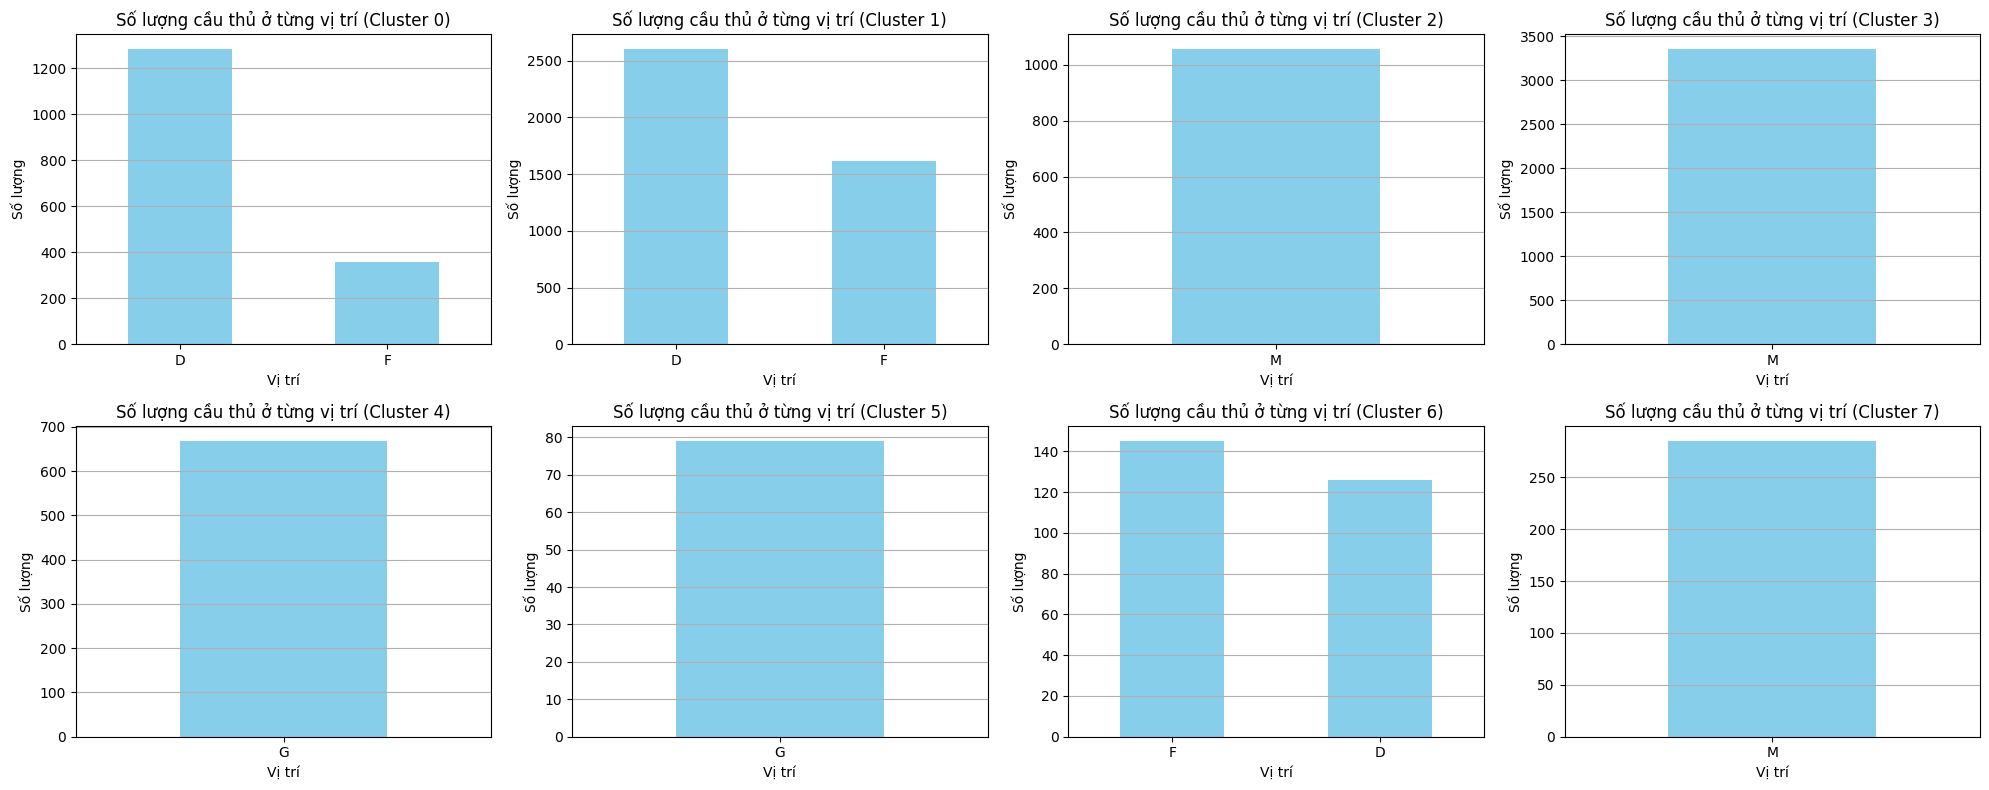

In [79]:
plt.figure(figsize=(20, 8))
for i, cluster_data in enumerate(clusters):
    positions = cluster_data['position']
    position_counts = positions.value_counts()
    plt.subplot(2, 4, i+1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Cụm 2, 3 và 7: có duy nhất vị trí cầu thủ là Tiền về(M)
- Cụm 4 và 5: có duy nhất vị trí cầu thủ là Thủ môn(G)
- Cụm 0, 1 và 6: có cả 2 vị trí cầu thù là Tiền đạo(F) và Hậu vệ(D)

``Khảo sát theo (độ tuổi, chiều cao, điểm số trung bình trong 12 tháng gần nhất, số lần xuất hiện trong 12 tháng gần nhất )``

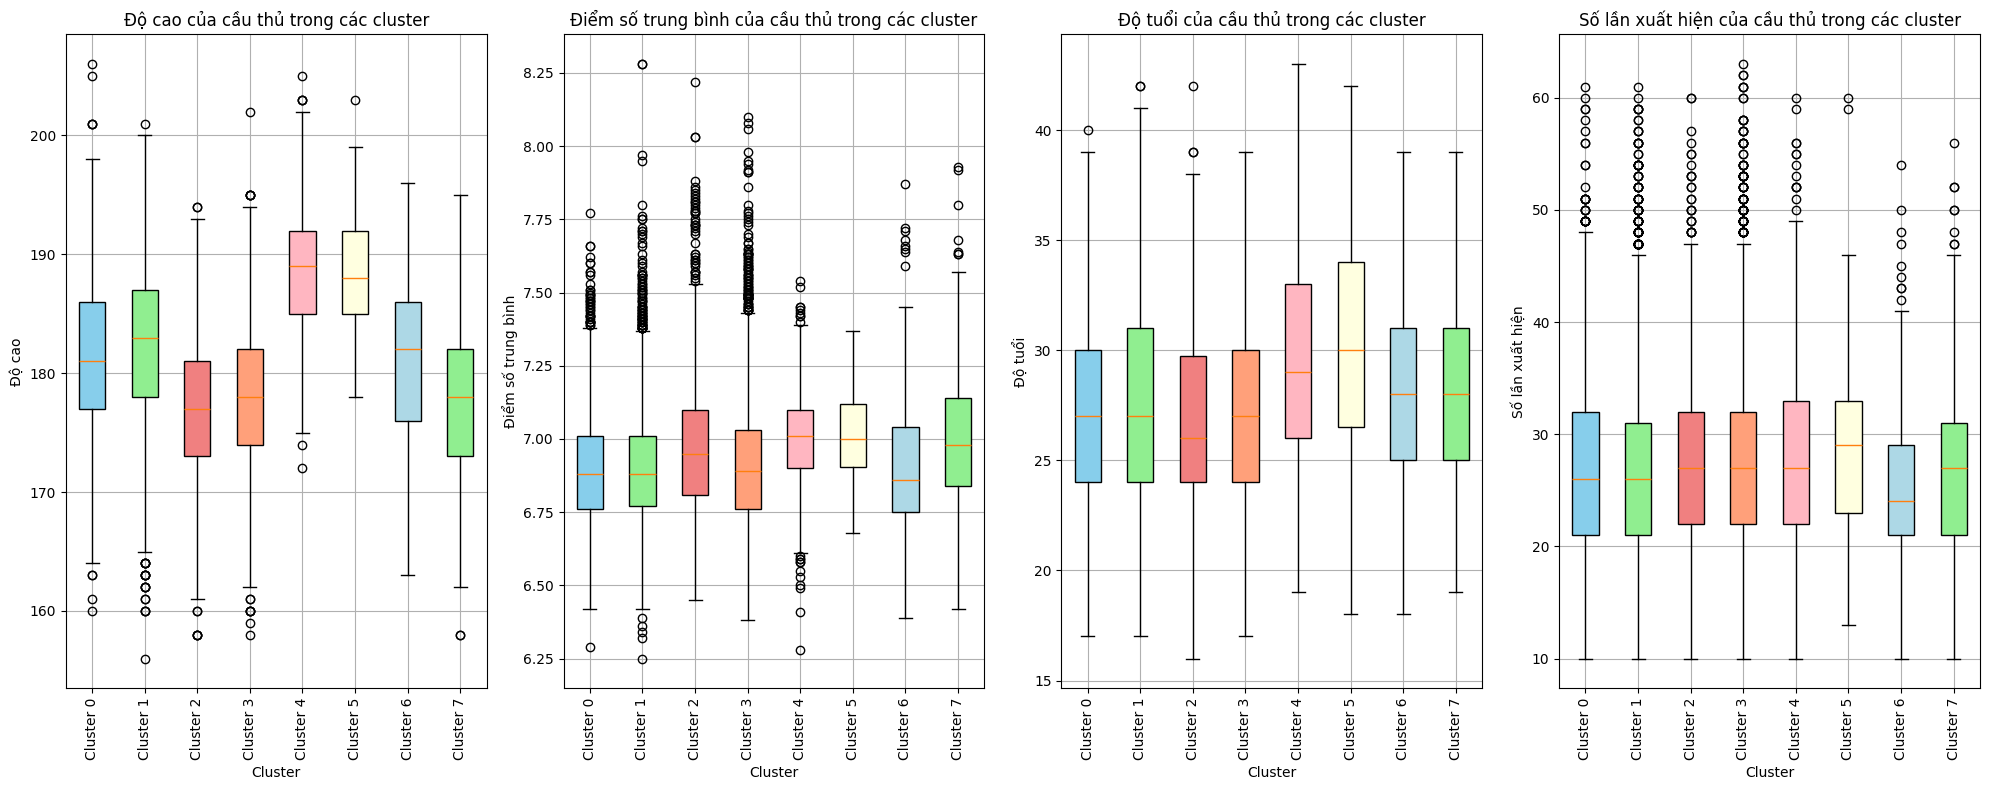

In [80]:
plt.figure(figsize=(20, 8))
# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()

#     plt.subplot(1, 4, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ cao
plt.subplot(1, 4, 1)
boxplot_height = plt.boxplot(clusters_height, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ cao của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ cao')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho điểm số trung bình
plt.subplot(1, 4, 2)
boxplot_scores = plt.boxplot(clusters_scores, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 
        'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_scores['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Điểm số trung bình của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Điểm số trung bình')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ tuôi
plt.subplot(1, 4, 3)
boxplot_height = plt.boxplot(clusters_age, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ tuổi của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ tuổi')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho số lần xuất hiện
plt.subplot(1, 4, 4)
boxplot_height = plt.boxplot(clusters_appearances_last_12_months, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Số lần xuất hiện của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Tiền đạo(F) và Hậu về(D): Tiên đạo và Hậu vệ nằm trong cụm 0, 1 và 6 có các thông số khá tương đồng nhau
- Các cụm về Tiền vệ(M): Tiền vệ trong các cụm 2, 3 và 7 có các chỉ số khá tương đồng nhau
- Cụm về Thủ môn(G): Cụm 5 là cụm chỉ riêng Thủ môn mang rõ đặc trưng của vai trò thủ môn khi có Chiều cao và độ tuổi trung bình lơn

``Khảo sát theo các chỉ số (9 chỉ số)``

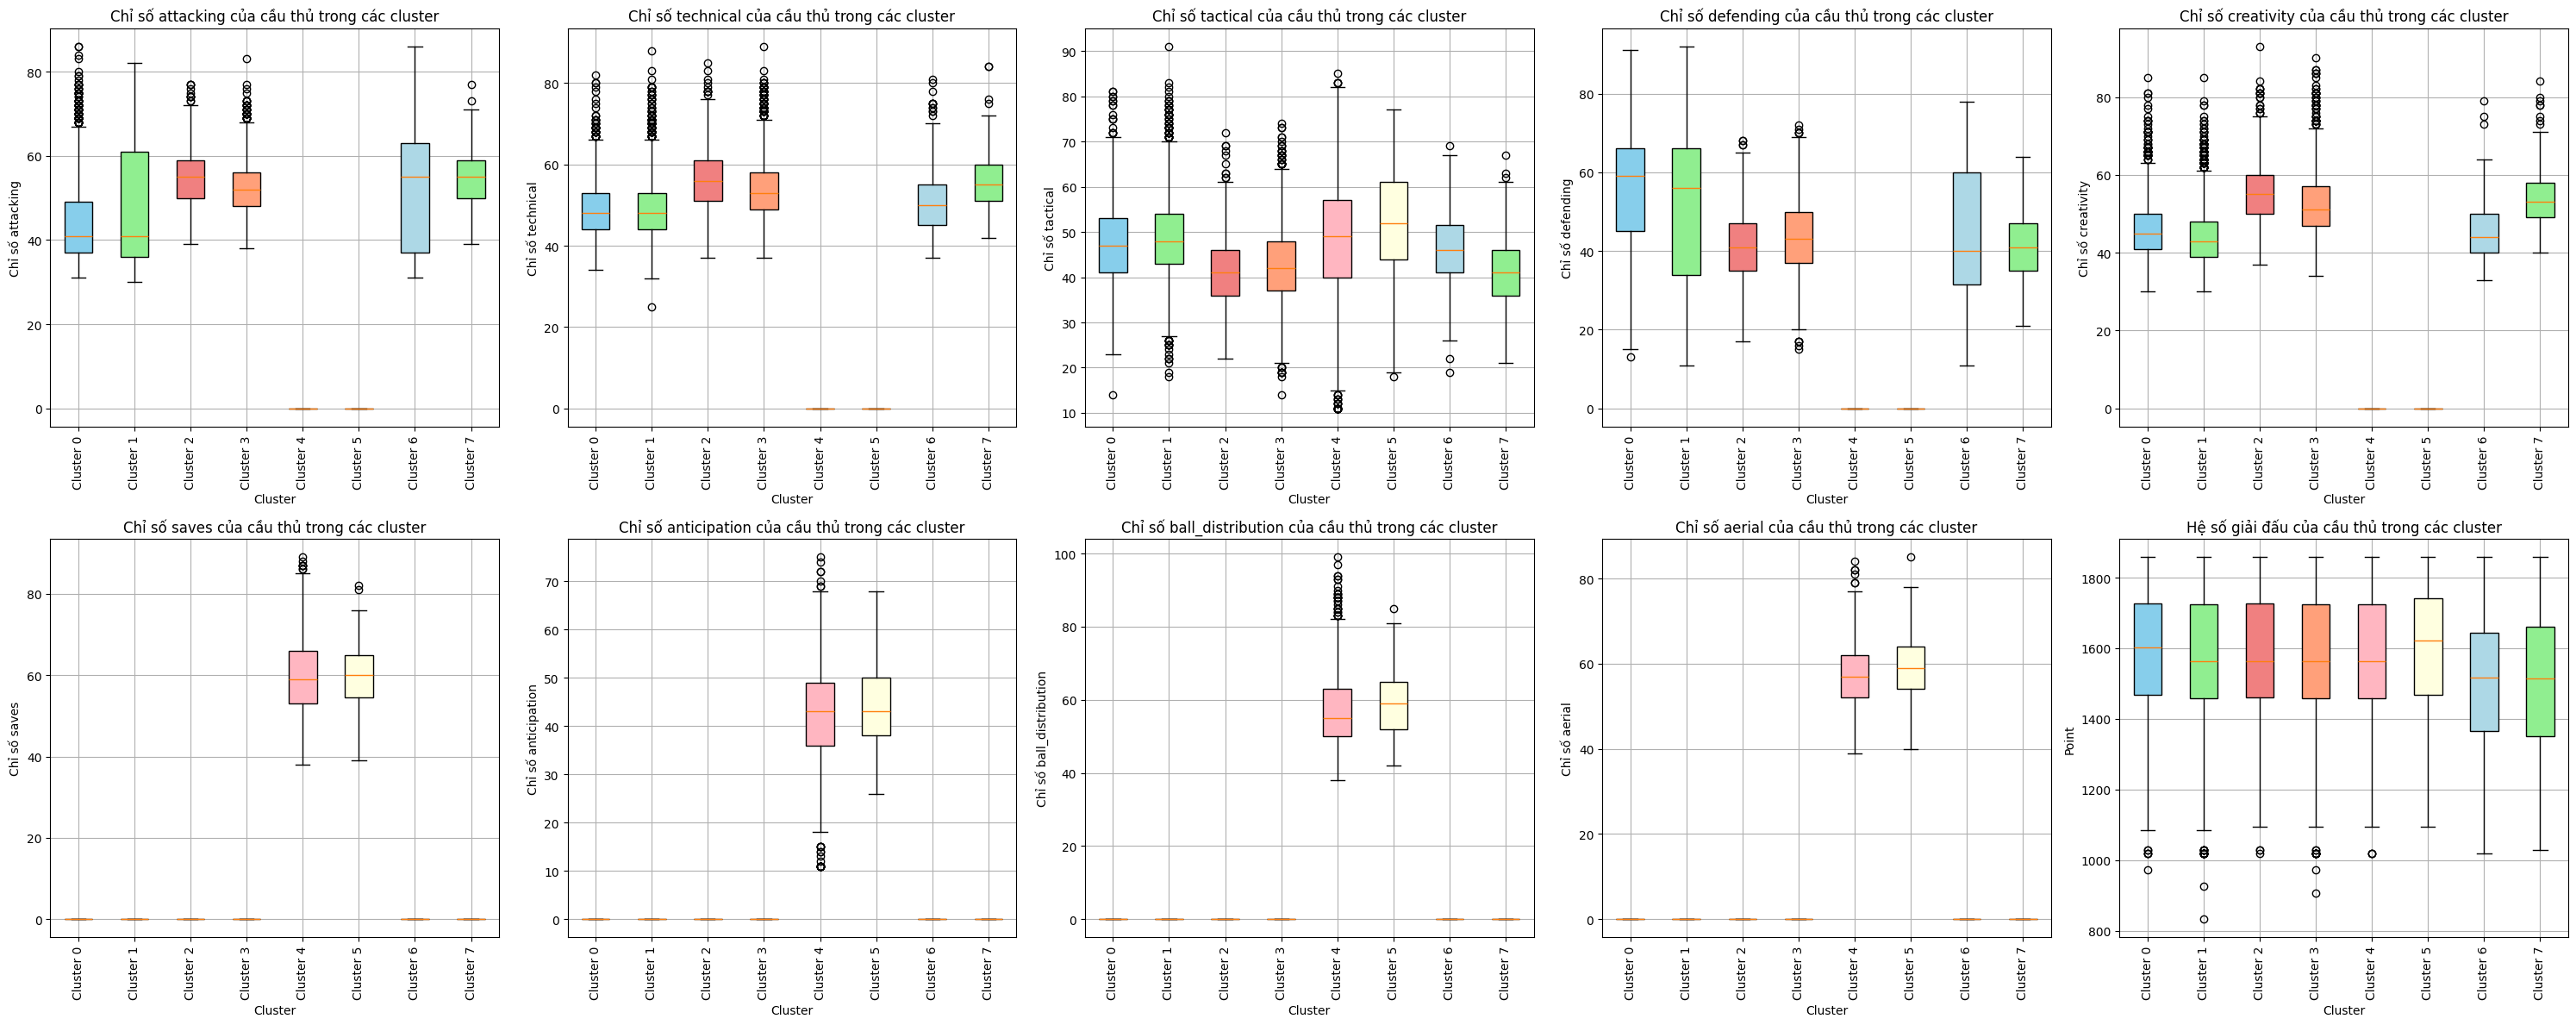

In [81]:
plt.figure(figsize=(30, 12))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()
#     plt.subplot(4, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho attacking
plt.subplot(2, 5, 1)
boxplot_height = plt.boxplot(clusters_attacking, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số attacking của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số attacking')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho technical
plt.subplot(2, 5, 2)
boxplot_height = plt.boxplot(clusters_technical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số technical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số technical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho tactical
plt.subplot(2, 5, 3)
boxplot_height = plt.boxplot(clusters_tactical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số tactical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số tactical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho defending
plt.subplot(2, 5, 4)
boxplot_height = plt.boxplot(clusters_defending, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số defending của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số defending')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho creativity
plt.subplot(2, 5, 5)
boxplot_height = plt.boxplot(clusters_creativity, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số creativity của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số creativity')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho saves
plt.subplot(2, 5, 6)
boxplot_height = plt.boxplot(clusters_saves, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số saves của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số saves')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho anticipation
plt.subplot(2, 5, 7)
boxplot_height = plt.boxplot(clusters_anticipation, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số anticipation của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số anticipation')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho ball_distribution
plt.subplot(2, 5, 8)
boxplot_height = plt.boxplot(clusters_ball_distribution, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số ball_distribution của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số ball_distribution')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho aerial
plt.subplot(2, 5, 9)
boxplot_height = plt.boxplot(clusters_aerial, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số aerial của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số aerial')
plt.xticks(rotation=90)
plt.grid(True)
# -----------------------------------------------------------------
# Biểu đồ boxplot cho hệ số giải đấu
plt.subplot(2, 5, 10)
boxplot_height = plt.boxplot(clusters_point_of_tournament, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Hệ số giải đấu của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Point')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()

**Nhận xét:**
- Các cụm về Hậu về (D) và Tiền vệ(F): các cầu thủ trong các cụm 0, 1 và 6 có các chỉ số khá tương đồng nhau. Riêng các cầu thủ ở cụm 1 và 6 có chỉ số Attacking cao hơn cụm còn lại, Các cầu thủ ở cụm 0 và 1 có chỉ số Defending cao hơn cụm còn lại. Cụm 6 là các cầu thủ thi đấu ở giải đấu có hệ số thấp hơn
- Cụm về Tiền vệ(M): Các cầu thủ trong các cụm 2, 3 và 7 có các chỉ số khá tương đồng nhau. Riêng cầu thủ ở cụm 2 và 7 có chỉ số Attacking, Technical và Creatitivy cao hơn đôi chút với cụm còn lại, ngược lại cụm 3 lại có chỉ số Tactical và Defending cao hơn. Cụm 7 là các cầu thủ thi đấu ở giải đấu có hệ số thấp hơn
- Cụm về Thủ môn(G): Cụm 5 là các thủ môn có chỉ số Tactical, Anticipation, Ball_distribution và Aerial cao hơn so với cụm 4, tuy nhiên chỉ số Saves lại kém hơn.

``Khảo sát theo vị trí, chân đá``

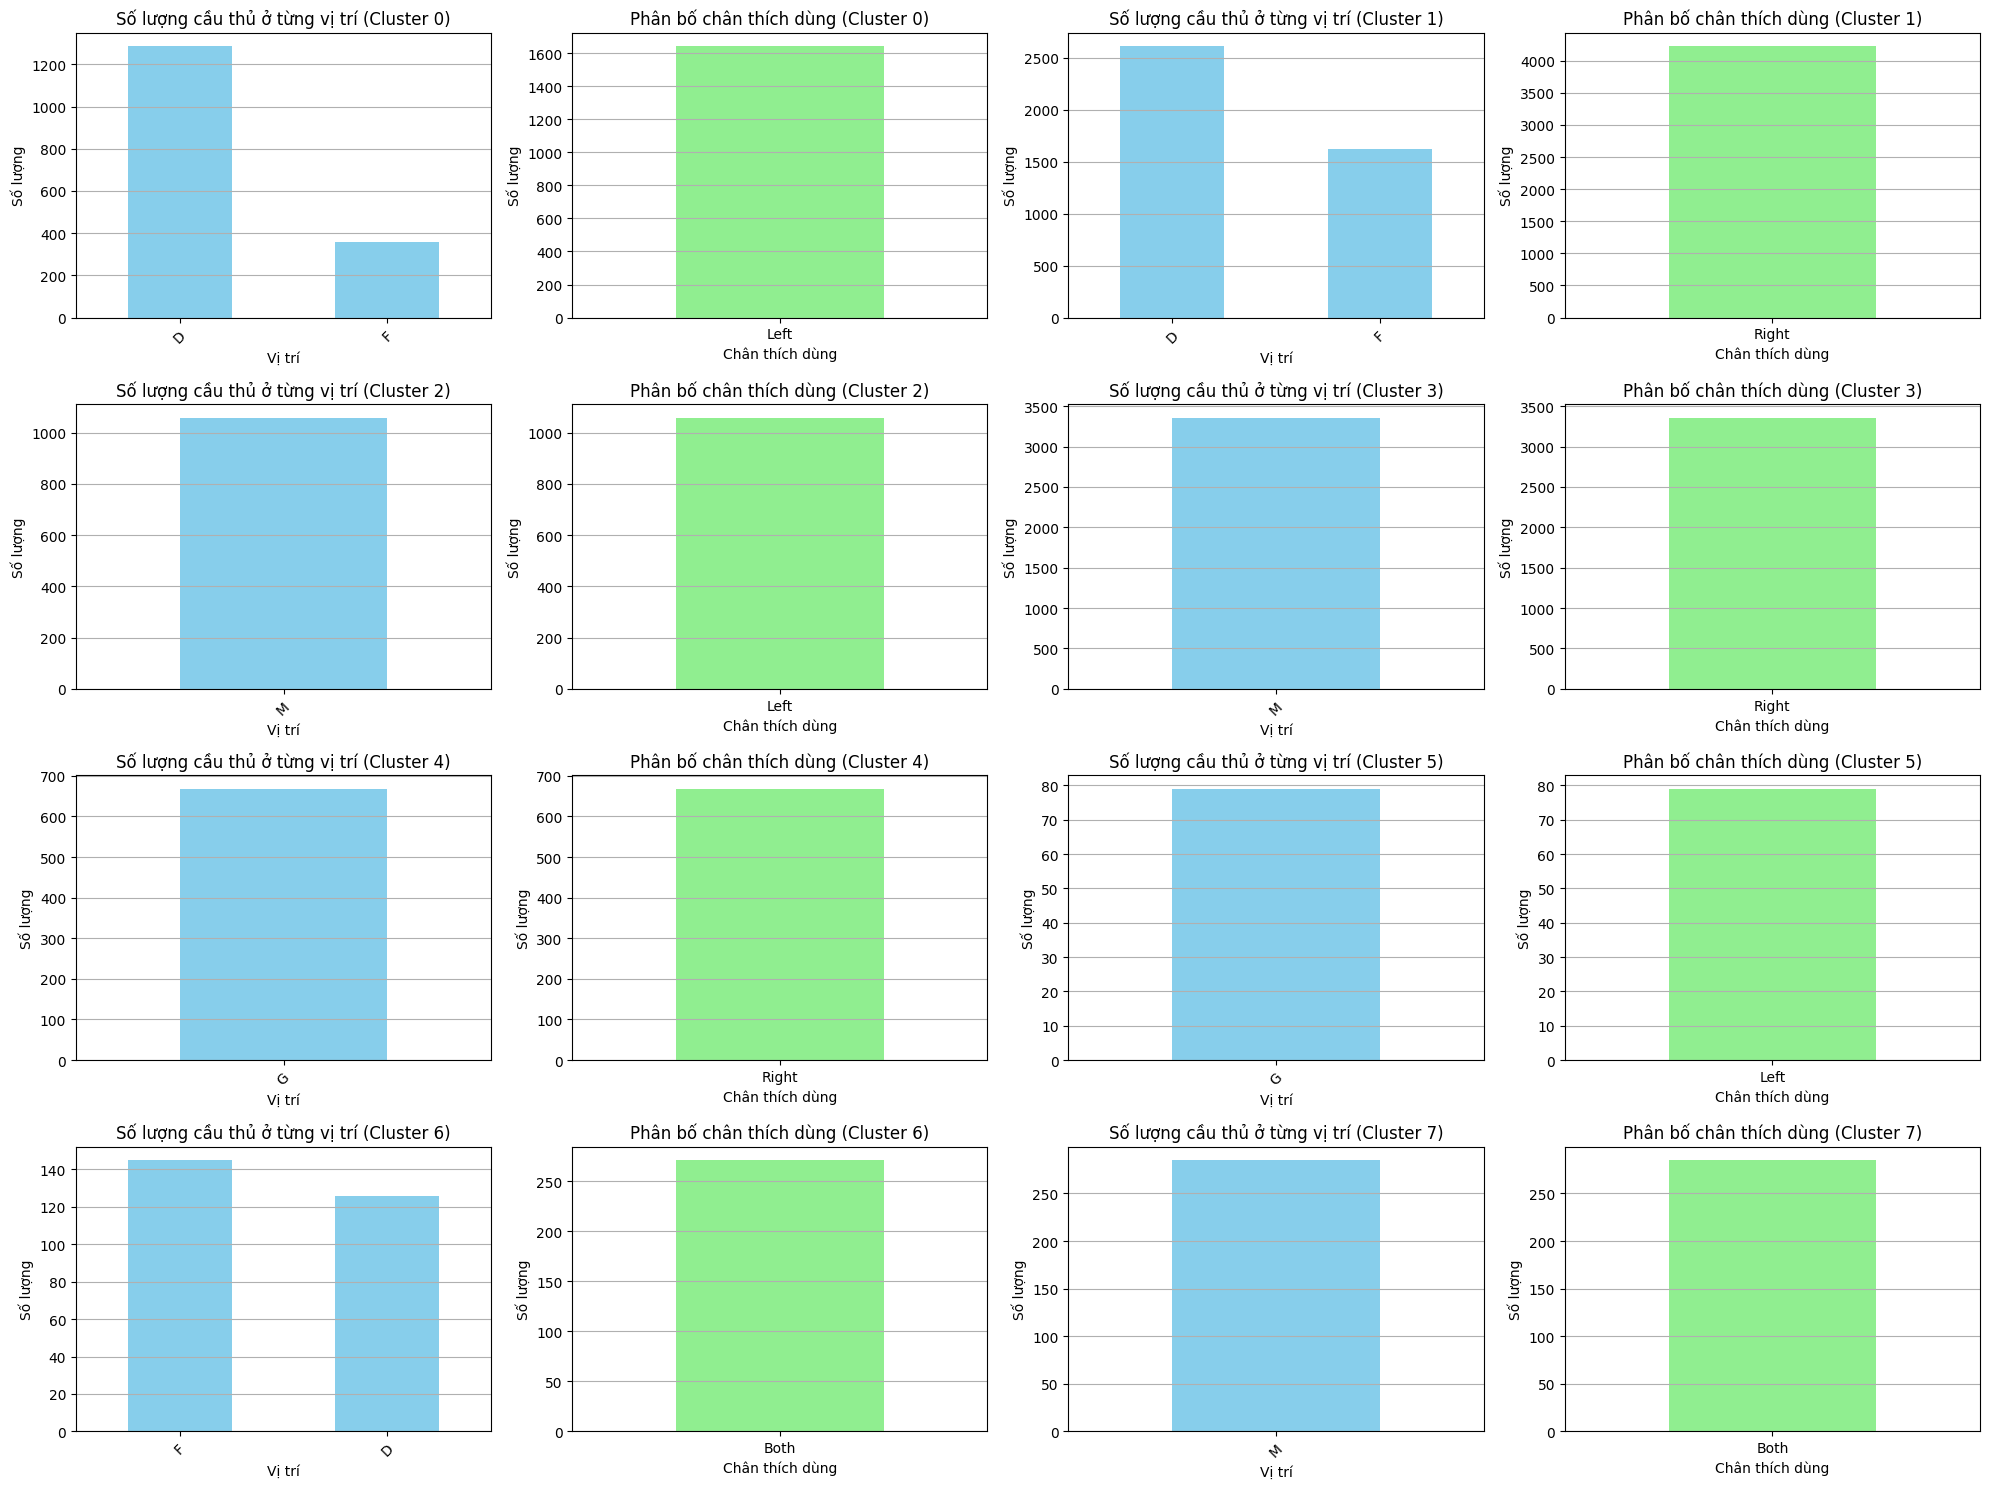

In [82]:
plt.figure(figsize=(20, 15))

for i, cluster_data in enumerate(clusters):
    positions = cluster_data['position']
    preferred_foot = cluster_data['preferred_foot']
    position_counts = positions.value_counts()
    foot_counts = preferred_foot.value_counts()

    # Biểu đồ số lượng cầu thủ ở từng vị trí
    plt.subplot(4, 4, (2 * i) + 1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Biểu đồ phân bố chân thích dùng
    plt.subplot(4, 4, (2 * i) + 2)
    foot_counts.plot(kind='bar', color='lightgreen')
    plt.title(f'Phân bố chân thích dùng (Cluster {i})')
    plt.xlabel('Chân thích dùng')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Các cụm về Hậu về (D) và Tiền vệ(F): 
    + Cầu thủ cụm 0 sở trường đá chân Trái.
    + Cầu thủ cụm 1 sở trường đá chân Phải.
    + Cầu thủ cụm 6 sở trường cả 2 chân.
- Cụm về Tiền vệ(M):
    + Tiền vệ cụm 3 sở trường đá chân Phải.
    + Tiền vệ cụm 2 sở trường đá chân Trái
    + Tiền vệ cụm 7 sở trường cả 2 chân.
- Cụm về Thủ môn(G):
    + Thủ môn cụm 4 sở trường đá chân Phải.
    + Thủ môn cụm 5 sở trường đá chân Trái.

``Khảo sát theo giá trị thị trường``

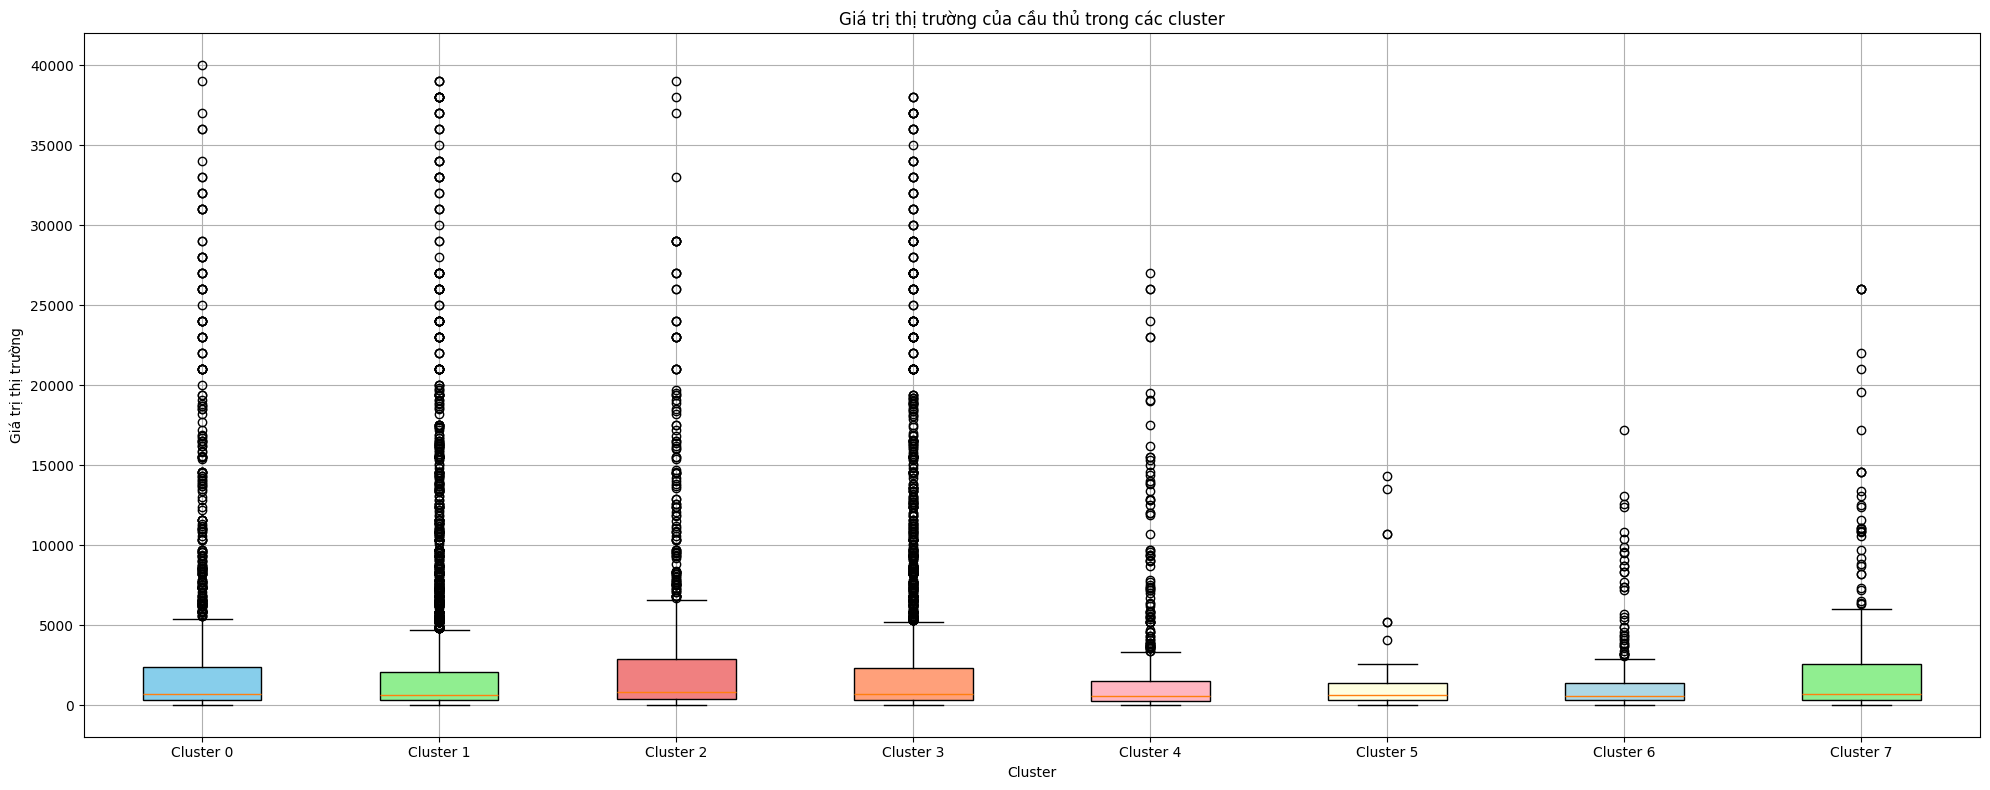

In [83]:
plt.figure(figsize=(20, 8))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()

#     plt.subplot(3, 3, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=45)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho giá trị thị trường 
# plt.subplot(3, 3, 9)
boxplot_height = plt.boxplot(clusters_market_value, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Giá trị thị trường của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Giá trị thị trường')
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Hậu về (D) và Tiền vệ(F): các cầu thủ trong cụm 0 có giá trị trường trung bình cao nhất trong các cụm Tiền đạo và Hậu về, Cụm 6 có giá trị thị trường trung bình thấp nhất
- Cụm về Tiền vệ(M): Các tiền vệ trong cụm 2 có giá trị thị trường trung bình cao nhất, tiền vệ cụm 3 giá trị thị trường trung bình thấp nhưng có nhiều cá biệt có giá trị thị trường cao đáng kể
- Cụm về Thủ môn(G): Các thủ môn trong cụm 4 có giá trị thị trường cao hơn cụm 5 và cũng có nhiều cầu thủ cá biệt có giá trị thị trường cao đáng kể.

**``Kết luận``**
- Phương pháp phân cụm dựa trên mật độ **Density-Based Clustering** cho ra kết quả các cụm có một số tính chất khác và cũng có một số tính chất mà một số cụm có sự tương đồng về giá trị biến dữ liệu tùy theo việc xác định tham số minPts và Epsilon 
- **DBSCAN** cho ra kết quả phân cụm không thể hiển tốt mỗi quan hệ giữa các cụm.
- Các cụm thu đường:
    + Cụm 0: Là Tiền đạo/Tiền vệ, defending khá cao, chân trái, giá trị trung bình cao
    + Cụm 1: Là Tiền đạo/Tiền vệ, attacking|defending khá cao, chân phải
    + Cụm 2: Là Tiền vệ, attacking|technical|creativity trung bình cao, chân trái, giá trị trung bình cao
    + Cụm 3: Là Tiền vệ, defending|tactical trung bình cao, chỉ số cao toàn diện, chân phải, giá trị trung bình thấp
    + Cụm 4: Là Thủ môn, saves cao, chân phải, giá trị trung bình cao
    + Cụm 5: Là Thủ môn, tactical|anticipation|ball_distribution|aerial cao, saves trung bình, chân trái
    + Cụm 6: Là Tiền đạo/Tiền vệ, attacking khá cao, giá đấu nhỏ, thuận 2 chân, giá trị trung bình thấp
    + Cụm 7: Là Tiền vệ, attacking|technical|creativity trung bình cao, giải đấu nhỏ, thuận 2 chân

### 4. Kết luận, đánh giá chung

``Nhận xét``:
- Cả 2 phương pháp phân cụm **Hierarchical Clustering** và **DBSCAN** đều cho ra các cụm có các tính chất khác nhau khi dùng các tham số đầu vào của mô hình một cách thích hợp
- Cả 2 phương pháp đều hỗ trợ phân cụm dữ liệu mà không cần xác định trước số cụm
- **Hierarchical Clustering** mất thời gian tính toán trên tập dữ liệu lớn nhưng cho ra kết quả phân cụm thể hiển tốt mỗi quan hệ giữa các cụm. Trong khi **DBSCAN** có thể xử lý các điểm nhiễu hiệu quả hơn nhưng khó khăn trong xử lý dữ liệu có nhiều điểm lân cận

``Kết luận``:
- Lựa chọn phương pháp **Hierarchical Clustering** để phân cụm dữ liệu
- Các cụm thu đường:
    + Cụm 0: Là Hậu vệ, defending|tactical khá cao, attacking|technical|creativity thấp, chân phải, giá trị trung bình
    + Cụm 1: Là Tiền vệ, hay ra sân, giải đấu lớn, attacking|technical|creativity khá cao, defending|tactical trung bình, chân trái|số ít thuận 2 chân, giá trị trung bình cao
    + Cụm 2: Là Tiền vệ, hay ra sân, giải dấu lớn, attacking|technical|creativity trung bình, defending|tactical khá cao, chân phải, giá trị trung bình cao
    + Cụm 3: Là Tiền đạo/Hậu vệ, trẻ, hay ra sân, giải đấu lớn, chỉ số cao toàn diện, chân phải, giá trị cao
    + Cụm 4: Là Tiền đạo/Hậu vệ, attacking|technical|creativity cao, chân trái, giá trị trung bình cao
    + Cụm 5: Là Thủ môn, cao, lớn tuổi, tactical cao, chân phải|số ít chân trái hoặc cả 2 chân
    + Cụm 6: Là Tiền đạo, chỉ số thấp, chân phải, giá trị trung bình thấp
    + Cụm 7: Là Hậu vệ, defending|tactical trung bình, attacking|technical|creativity khá cao, chân trái, giá trị trung bình
    + Cụm 8: Là Tiền vệ, ít ra sân, giải đấu nhỏ, chỉ số thấp, chân phải, giá trị thấp